# Selection of $B_s \rightarrow \psi(2S)\,K_S$ events: A lab exercise

In this notebook you will perform the (most interesting) part of a **real physics data analysis** of the $B_s \rightarrow \psi(2S)\,K_S$ decay:  
The filtering of the tiny fraction of interesting events from the vast amount of total data that is recorded in the LHCb experiment at CERN.  
You will be learning about classification tasks in particle physics, utilizing machine learning algorithms and expert systems to squeeze out the best performance.  
But let's not panic, we go through it step by step!

We will work on three samples:
- The real data set.
- Monte-Carlo simulation of the signal decay $B_s^0 \rightarrow \psi(2S)\,K_S$.
- Monte-Carlo simulation of the (kinematically) similar decay $B_d^0 \rightarrow \psi(2S)\,K_S$.


Let's first define the paths to the samples.

In [1]:
# python scientific computing
import numpy as np

# python plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib styles for scientific figures
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

import pandas as pd

from scipy import stats

# dpi resolution to save images
image_save_dpi = 1200

In [2]:
# actual data
path_to_data = '/data/Bs2psi2SKS/data.root'

# signal simulation
path_to_sim = '/data/Bs2psi2SKS/signal_sim.root'

# control channel simulation
path_to_control_sim = '/data/Bd2psi2SKS/control_sim.root'

In [3]:
path='images/'
format='.pdf'

save=0

The nomenclature here is:
 - data = the actual data coming from LHCb
 - signal sim = monte-carlo simulation of our signal decay $B_s^0 \rightarrow \psi(2S)\,K_S$
 - control sim = monte-carlo simulation of the similar decay $B_d^0 \rightarrow \psi(2S)\,K_S$

### Reading the data from a "ROOT" file

Everything at CERN works with [ROOT](https://root.cern.ch), also the output of our distributed data processing chain.  
ROOT is incredibly powerful, but also not too easy to use..  
Let's not try to make it work, but rather use [uproot](https://github.com/scikit-hep/uproot) to put our data into [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [4]:
def get_data(path, chunk_size=None, treename = 'Tree', branches = None):
    
    import uproot
    if not chunk_size:
        return uproot.open(path)[treename].pandas.df(branches=branches, flatten=False).replace([np.inf, -np.inf], np.nan).dropna()
    for data in uproot.open(path)[treename].pandas.iterate(entrysteps = chunk_size, flatten=False, branches=branches):
        return data.replace([np.inf, -np.inf], np.nan).dropna()

## 1. Data Exploration
Let's have a look at our simulation first.

**Ex 1.1: Get a dataframe of the signal simulation and plot the invariant $B_s^0$ mass.**  
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">The name is B_FitDaughtersConst_M_flat</a></h4>

In [5]:
df_sim = get_data(path_to_sim)

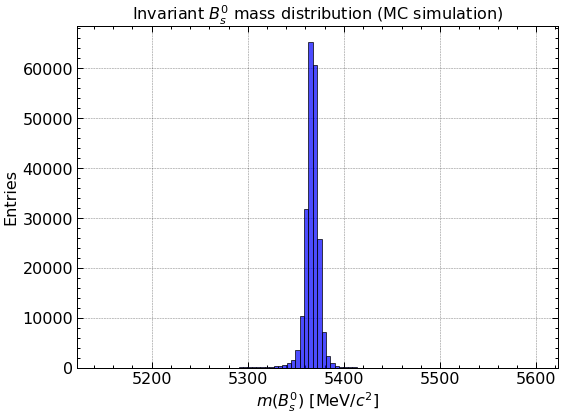

In [6]:
plt.figure(figsize=(8, 6))
h01, x01, _ = plt.hist(df_sim['B_FitDaughtersConst_M_flat'],
                       bins=100,
                       color='b',
                       alpha=0.7,
                       edgecolor='k')

plt.title('Invariant $B_s^0$ mass distribution (MC simulation)')
plt.xlabel('$m(B_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.tight_layout()
if save==1: plt.savefig(path+'m_B0S_MC'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()


In [7]:
df_control_sim = get_data(path_to_control_sim)

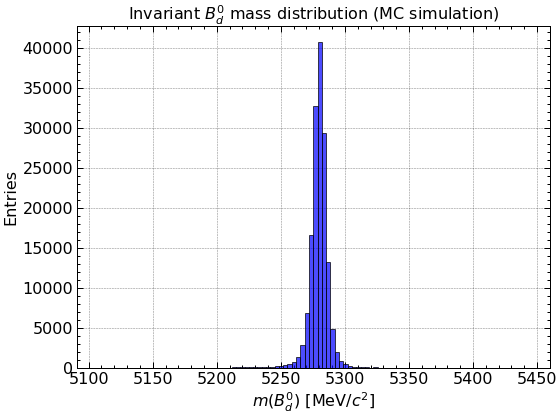

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(df_control_sim['B_FitDaughtersConst_M_flat'],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.title('Invariant $B_d^0$ mass distribution (MC simulation)')
plt.xlabel('$m(B_d^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.tight_layout()

if save==1: plt.savefig(path+'m_B0D_MC'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


Your plot should show a peaking structure near the nominal $B_s^0$ mass: $m(B_s^0) = 5366.88\,\text{MeV}$.


Let's do the same for our data:

**Ex 1.2: Plot the invariant $B_s^0$ mass of the data.**

In [9]:
df_data = get_data(path_to_data)

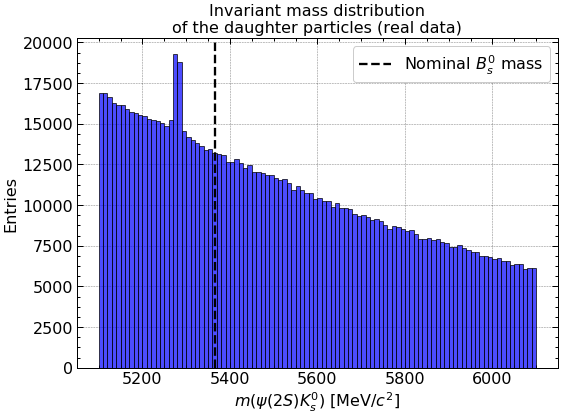

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_data['B_FitDaughtersConst_M_flat'],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.axvline(5366.88, color='k', linestyle='--', linewidth=2.3, 
            label='Nominal $B_s^0$ mass')

plt.title('Invariant mass distribution'
          '\n'
          'of the daughter particles (real data)')
plt.xlabel('$m(\psi(2S)K_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

if save==1: plt.savefig(path+'m_B0_real'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


While the LHC is running, millions of collisions happen every second at LHCb, resulting in 40Tb/s of data. The data you see here contains events from the entire Run 2 of the LHC (2015 - 2018), but obviously already **heavily preselected** by the trigger and other centralized selections.

Still, the amount of (for our purposes) uninteresting events is still overwhelming, and this is what you see in the mass distribution. The $B_s^0 \rightarrow \psi(2S)\,K_S$ signal events are hiding somewhere in this mess. And besides the peaking structure (which does not correspond to the $B_s^0$), the data sample is dominated by **combinatorial background**.

Our goal is to find the needles in the haystack here, so lets get on with it!

Here is an **outline** of the tasks ahead:
 2. Define a **signal window** and a **background sample**
 3. **Select features** that discriminate signal and background well
 4. Build an algorithm that tries to **predict how signal-like** an event is, using these features
 5. **Optimize a threshold** to split the data into signal and background
 6. Apply the classification to the signal window in our data and **fit** the resulting distribution to
    quantify how clearly we can make out $B_s^0 \rightarrow \psi(2S)\,K_S$

## 2.  Define signal and background training samples

We will train our classifier on signal and background samples.

### 2.1 Signal window and background sample
**Ex 2.1:**  
**Define a window in which we expect signal to appear: The shortest interval that contains 99\% of the signal-MC mass distribution and visualize your result**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Compute all intervalls containing 99% and take the shortest.</a></h4>

In [11]:
# Function to compute the shortest interval that contains 99%
# of the signal-MC mass distribution.
# Starting from the maximum bin, we add extend the interval to the
# left and right bin; then we measure the percentage:
# if greater, than 99% ---> done
# otherwise, continue extending the interval to the
# left and right bin.
# It depends on the choosen binning!

def min_interval(hist, x):
    
    tot = hist.sum()
    
    # hist bin with max
    x_max = np.argmax(hist)
    
    # set size to the minimum number of bins
    # at the left or right of the maximum one
    size = min((x_max),(len(hist)-x_max))
    
    # vec[0]: bin start point
    # vec[1]: bin end point
    # vec[2]: percentage
    vec = np.zeros(3)
    percent=hist[x_max]/tot
    
    j=1
    while (j<=size)&(percent<=0.99):
        vec[0]=x[x_max-j]
        vec[1]=x[x_max+j]
        percent+=((hist[x_max-j]/tot)+(hist[x_max+j]/tot))
        vec[2]=percent
        j+=1
    
    return (vec[0], vec[1])

In [12]:
min_int = min_interval(h01, x01)

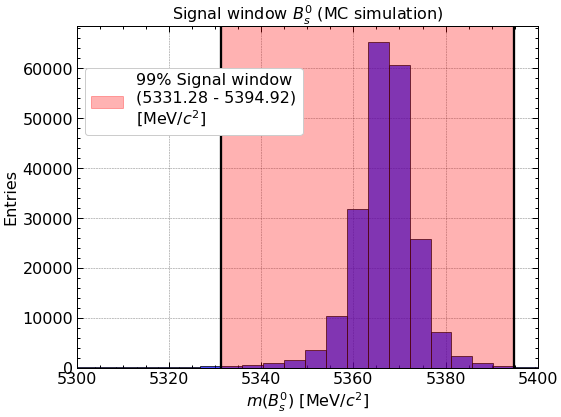

In [13]:
plt.figure(figsize=(8, 6))
plt.hist(df_sim['B_FitDaughtersConst_M_flat'],
         bins=100,  # same binning as before
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.axvspan(*min_int, alpha=0.3, color='r',
           label=f'99% Signal window\n({min_int[0]:.2f} - {min_int[1]:.2f})\n[MeV/$c^2$]')

plt.axvline(min_int[0], color='k', linestyle='-', linewidth=2.3)
plt.axvline(min_int[1], color='k', linestyle='-', linewidth=2.3)

plt.xlim((5300, 5400))  # but xlim to zoom on the signal window

plt.title('Signal window $B_s^0$ (MC simulation)')
plt.xlabel('$m(B_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.tight_layout()

if save==1: plt.savefig(path+'sig_window'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


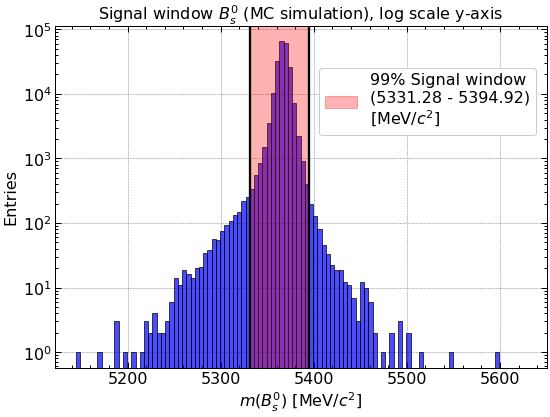

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(df_sim['B_FitDaughtersConst_M_flat'],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.axvspan(*min_int, alpha=0.3, color='r',
           label=f'99% Signal window\n({min_int[0]:.2f} - {min_int[1]:.2f})\n[MeV/$c^2$]')

plt.axvline(min_int[0], color='k', linestyle='-', linewidth=2.3)
plt.axvline(min_int[1], color='k', linestyle='-', linewidth=2.3)

plt.xlim(right = 5650)  # needed only to make the legend fit

plt.title('Signal window $B_s^0$ (MC simulation), log scale y-axis')
plt.xlabel('$m(B_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.legend(loc='upper left', bbox_to_anchor=(0.52, 0.9))
plt.yscale('log')
plt.tight_layout()

if save==1: plt.savefig(path+'sig_window_log'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


Now that we have defined a signal window, lets see where it is in the data mass distribution.  

**Ex 2.2: Plot the data mass distribution with the signal window**

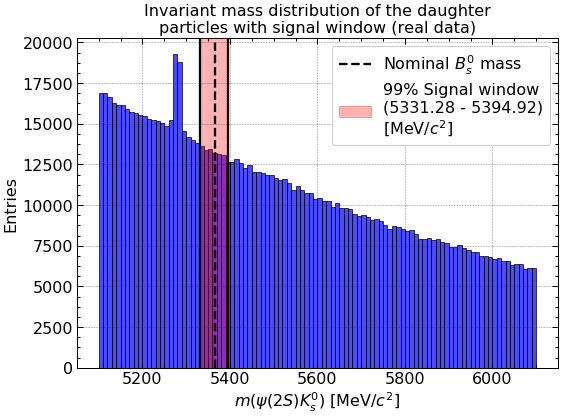

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(df_data['B_FitDaughtersConst_M_flat'],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.axvline(5366.88, color='k', linestyle='--', linewidth=2.3, 
            label='Nominal $B_s^0$ mass')

plt.axvspan(*min_int, alpha=0.3, color='r',
           label=f'99% Signal window\n({min_int[0]:.2f} - {min_int[1]:.2f})\n[MeV/$c^2$]')

plt.axvline(min_int[0], color='k', linestyle='-', linewidth=2.3)
plt.axvline(min_int[1], color='k', linestyle='-', linewidth=2.3)

plt.title('Invariant mass distribution of the daughter'
          '\n'
          'particles with signal window (real data)')
plt.xlabel('$m(\psi(2S)K_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

if save==1: plt.savefig(path+'sig_window_real'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


To train the classifier, we should never use the signal window because it could bias the classifier. Instead, we need to define suitable signal and background training samples to work on.  
Our signal sample will be the signal simulation, and as background we want to choose the **upper sideband (USB)** of the $B_s$ peak (yet invisble) in the data. The USB of the $B_s$ peak contains the events with reconstructed $B_s$ masses larger than the nominal $B_s$ mass. It contains only combinatorial background and is therefore perfect for the job, since this is what we want to get rid of.  

**Ex 2.3: Select the background sample**

In [16]:
bkg_sample = df_data[df_data["B_FitDaughtersConst_M_flat"] > min_int[1]].copy()


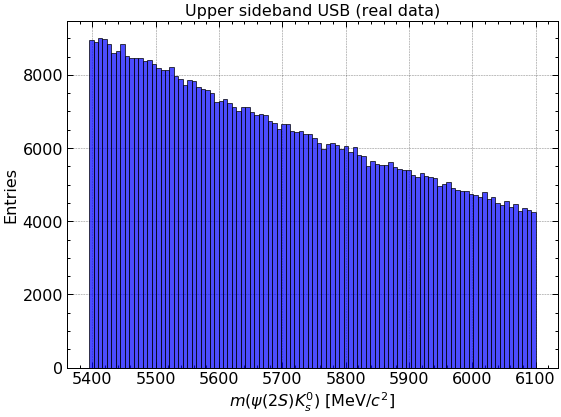

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(bkg_sample["B_FitDaughtersConst_M_flat"],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k')

plt.title('Upper sideband USB (real data)')
plt.xlabel('$m(\psi(2S)K_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.tight_layout()

if save==1: plt.savefig(path+'USB'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


### 2.2 Signal training sample
Our simulation algorithms are far from perfect, mainly due to imperfect theoretical physics models and our imperfect modelling of the detector to simulate responses. For example, some aspects of the decay kinematics are often imperfect in simulation and are corrected for using such weights, stored in the variable `kinematic_weights`. You should use these weights for everything from now on.

But other properties may be mis-modelled by the simulation as well. This means that even if you find the most discriminating variables now (using the`kinematic_weights`) and train a classifier with them, your classifier would only be able to classify simulation and data - instead of signal and background.

Therefore, we need to evaluate how similar simulation and data are in each variable without having $B_s^0$ data to compare the simulation with. And here we take advantage of the decay $B_d^0\to\psi(2S)K_S$. The $B_d^0$ decay is similar to the $B_s^0$ decay, especially in the kinematic variables which will be very important in the removal of combinatorial background. Additionally, the $B_d^0$ decay is very abundant, we can already see it by eye in the data set.

Fortunately, the sWeights `sweights_sig` giving us pure $B_d^0$ events from the data sample have already been computed.
**Caution:** sWeighted data distributions are only a reliable representation of the true distribution if the variable you look at is uncorrelated to the invariant $B_s^0$ mass.

**Ex. 2.4: Plot the reconstructed invariant mass of the $B_d^0$ meson in the data set with and without sWeights**

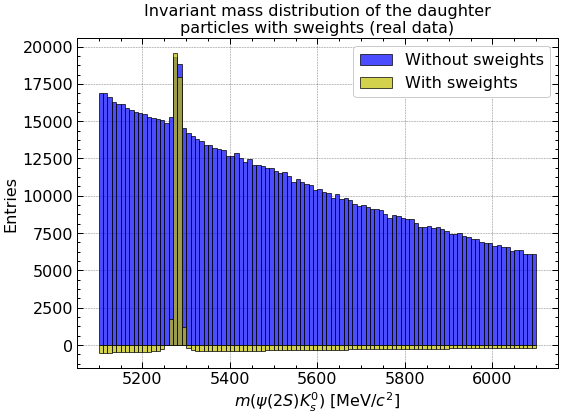

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(df_data['B_FitDaughtersConst_M_flat'],
         bins=100,
         color='b',
         alpha=0.7,
         edgecolor='k',
         label='Without sweights')

plt.hist(df_data['B_FitDaughtersConst_M_flat'],
         bins=100,
         weights=df_data['sweights_sig'],
         color='y',
         alpha=0.7,
         edgecolor='k',
         label='With sweights')

plt.title('Invariant mass distribution of the daughter'
          '\n'
          'particles with sweights (real data)')
plt.xlabel('$m(\psi(2S)K_s^0)$ [MeV/$c^2$]')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

if save==1: plt.savefig(path+'sweights'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


**Ex. 2.5: Compare the $B_d^0$ events in data with the $B_d^0$ simulation for each variable by eye**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Don't forget the weights in both samples.</a></h4>

In [19]:
all_vars = list(df_data.columns)
print(len(all_vars))
all_vars


863


['B_LOKI_ENERGY',
 'B_LOKI_ETA',
 'B_LOKI_PHI',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_MINIPNEXTBEST',
 'B_MINIPCHI2NEXTBEST',
 'B_ENDVERTEX_X',
 'B_ENDVERTEX_Y',
 'B_ENDVERTEX_Z',
 'B_ENDVERTEX_XERR',
 'B_ENDVERTEX_YERR',
 'B_ENDVERTEX_ZERR',
 'B_ENDVERTEX_CHI2',
 'B_OWNPV_X',
 'B_OWNPV_Y',
 'B_OWNPV_Z',
 'B_OWNPV_XERR',
 'B_OWNPV_YERR',
 'B_OWNPV_ZERR',
 'B_OWNPV_CHI2',
 'B_OWNPV_NDOF',
 'B_IP_OWNPV',
 'B_IPCHI2_OWNPV',
 'B_FD_OWNPV',
 'B_FDCHI2_OWNPV',
 'B_DIRA_OWNPV',
 'B_TOPPV_X',
 'B_TOPPV_Y',
 'B_TOPPV_Z',
 'B_TOPPV_XERR',
 'B_TOPPV_YERR',
 'B_TOPPV_ZERR',
 'B_TOPPV_CHI2',
 'B_TOPPV_NDOF',
 'B_IP_TOPPV',
 'B_IPCHI2_TOPPV',
 'B_FD_TOPPV',
 'B_FDCHI2_TOPPV',
 'B_DIRA_TOPPV',
 'B_P',
 'B_PT',
 'B_PE',
 'B_PX',
 'B_PY',
 'B_PZ',
 'B_MM',
 'B_MMERR',
 'B_M',
 'B_TAU',
 'B_TAUERR',
 'B_TAUCHI2',
 'B_LOKI_DIRA',
 'B_LOKI_DOCA',
 'B_LOKI_DOCACHI2',
 'B_LOKI_DTF_CHI2NDOF',
 'B_LOKI_DTF_CTAU',
 'B_LOKI_DTF_CTAUERR',
 'B_LOKI_DTF_CTAUERR_D2',
 'B_LOKI_DTF_CTAUS',
 'B_LOKI_DTF_C

In [20]:
def remove_entries_with_keywords(strings, keywords):
    """
    Remove entries from a list of strings that contain any of the specified keywords.
    
    Parameters:
    strings (list of str): The list of strings to filter.
    keywords (list of str): The keywords to look for in the strings.
    
    Returns:
    list of str: The filtered list of strings.
    """
    filtered_strings = []
    
    for string in strings:
        if not any(keyword in string for keyword in keywords):
            filtered_strings.append(string)
    
    return filtered_strings


In [21]:
#df_control_sim.columns

In [22]:
selected_vars = [ # some vars that could be useful, tbh I have no clue what vars we are supposed to look at here
    'B_LOKI_ENERGY',
    'B_LOKI_ETA',
    'B_LOKI_PHI',
    'B_Vtx_Chi2NDOF',
    'B_MINIP',
    'B_MINIPCHI2',
    'B_MINIPNEXTBEST',
    'B_MINIPCHI2NEXTBEST',
    'B_ENDVERTEX_CHI2',
    'B_OWNPV_CHI2',
    'B_IP_OWNPV',
    'B_IPCHI2_OWNPV',
    'B_FD_OWNPV',
    'B_FDCHI2_OWNPV',
    'B_DIRA_OWNPV',
    'B_P',
    'B_PT',
    'B_TAU',
    'B_LOKI_DOCA',
    'B_FitDaughtersConst_KS0_decayLength_flat',
    'B_FitJpsiConst_KS0_ctau_flat',
    'B_FitPVConst_decayLength_flat',
    'psi_2S_MINIP',
    'psi_2S_MINIPCHI2',
    'psi_2S_OWNPV_CHI2',
    'psi_2S_IP_OWNPV',
    'psi_2S_IPCHI2_OWNPV',
    'psi_2S_FD_OWNPV',
    'psi_2S_FDCHI2_OWNPV',
    'psi_2S_DIRA_OWNPV',
    'muplus_MINIP',
    'muminus_MINIP',
    'KS0_Vtx_Chi2NDOF',
    'KS0_MINIP',
]
len(selected_vars)


34

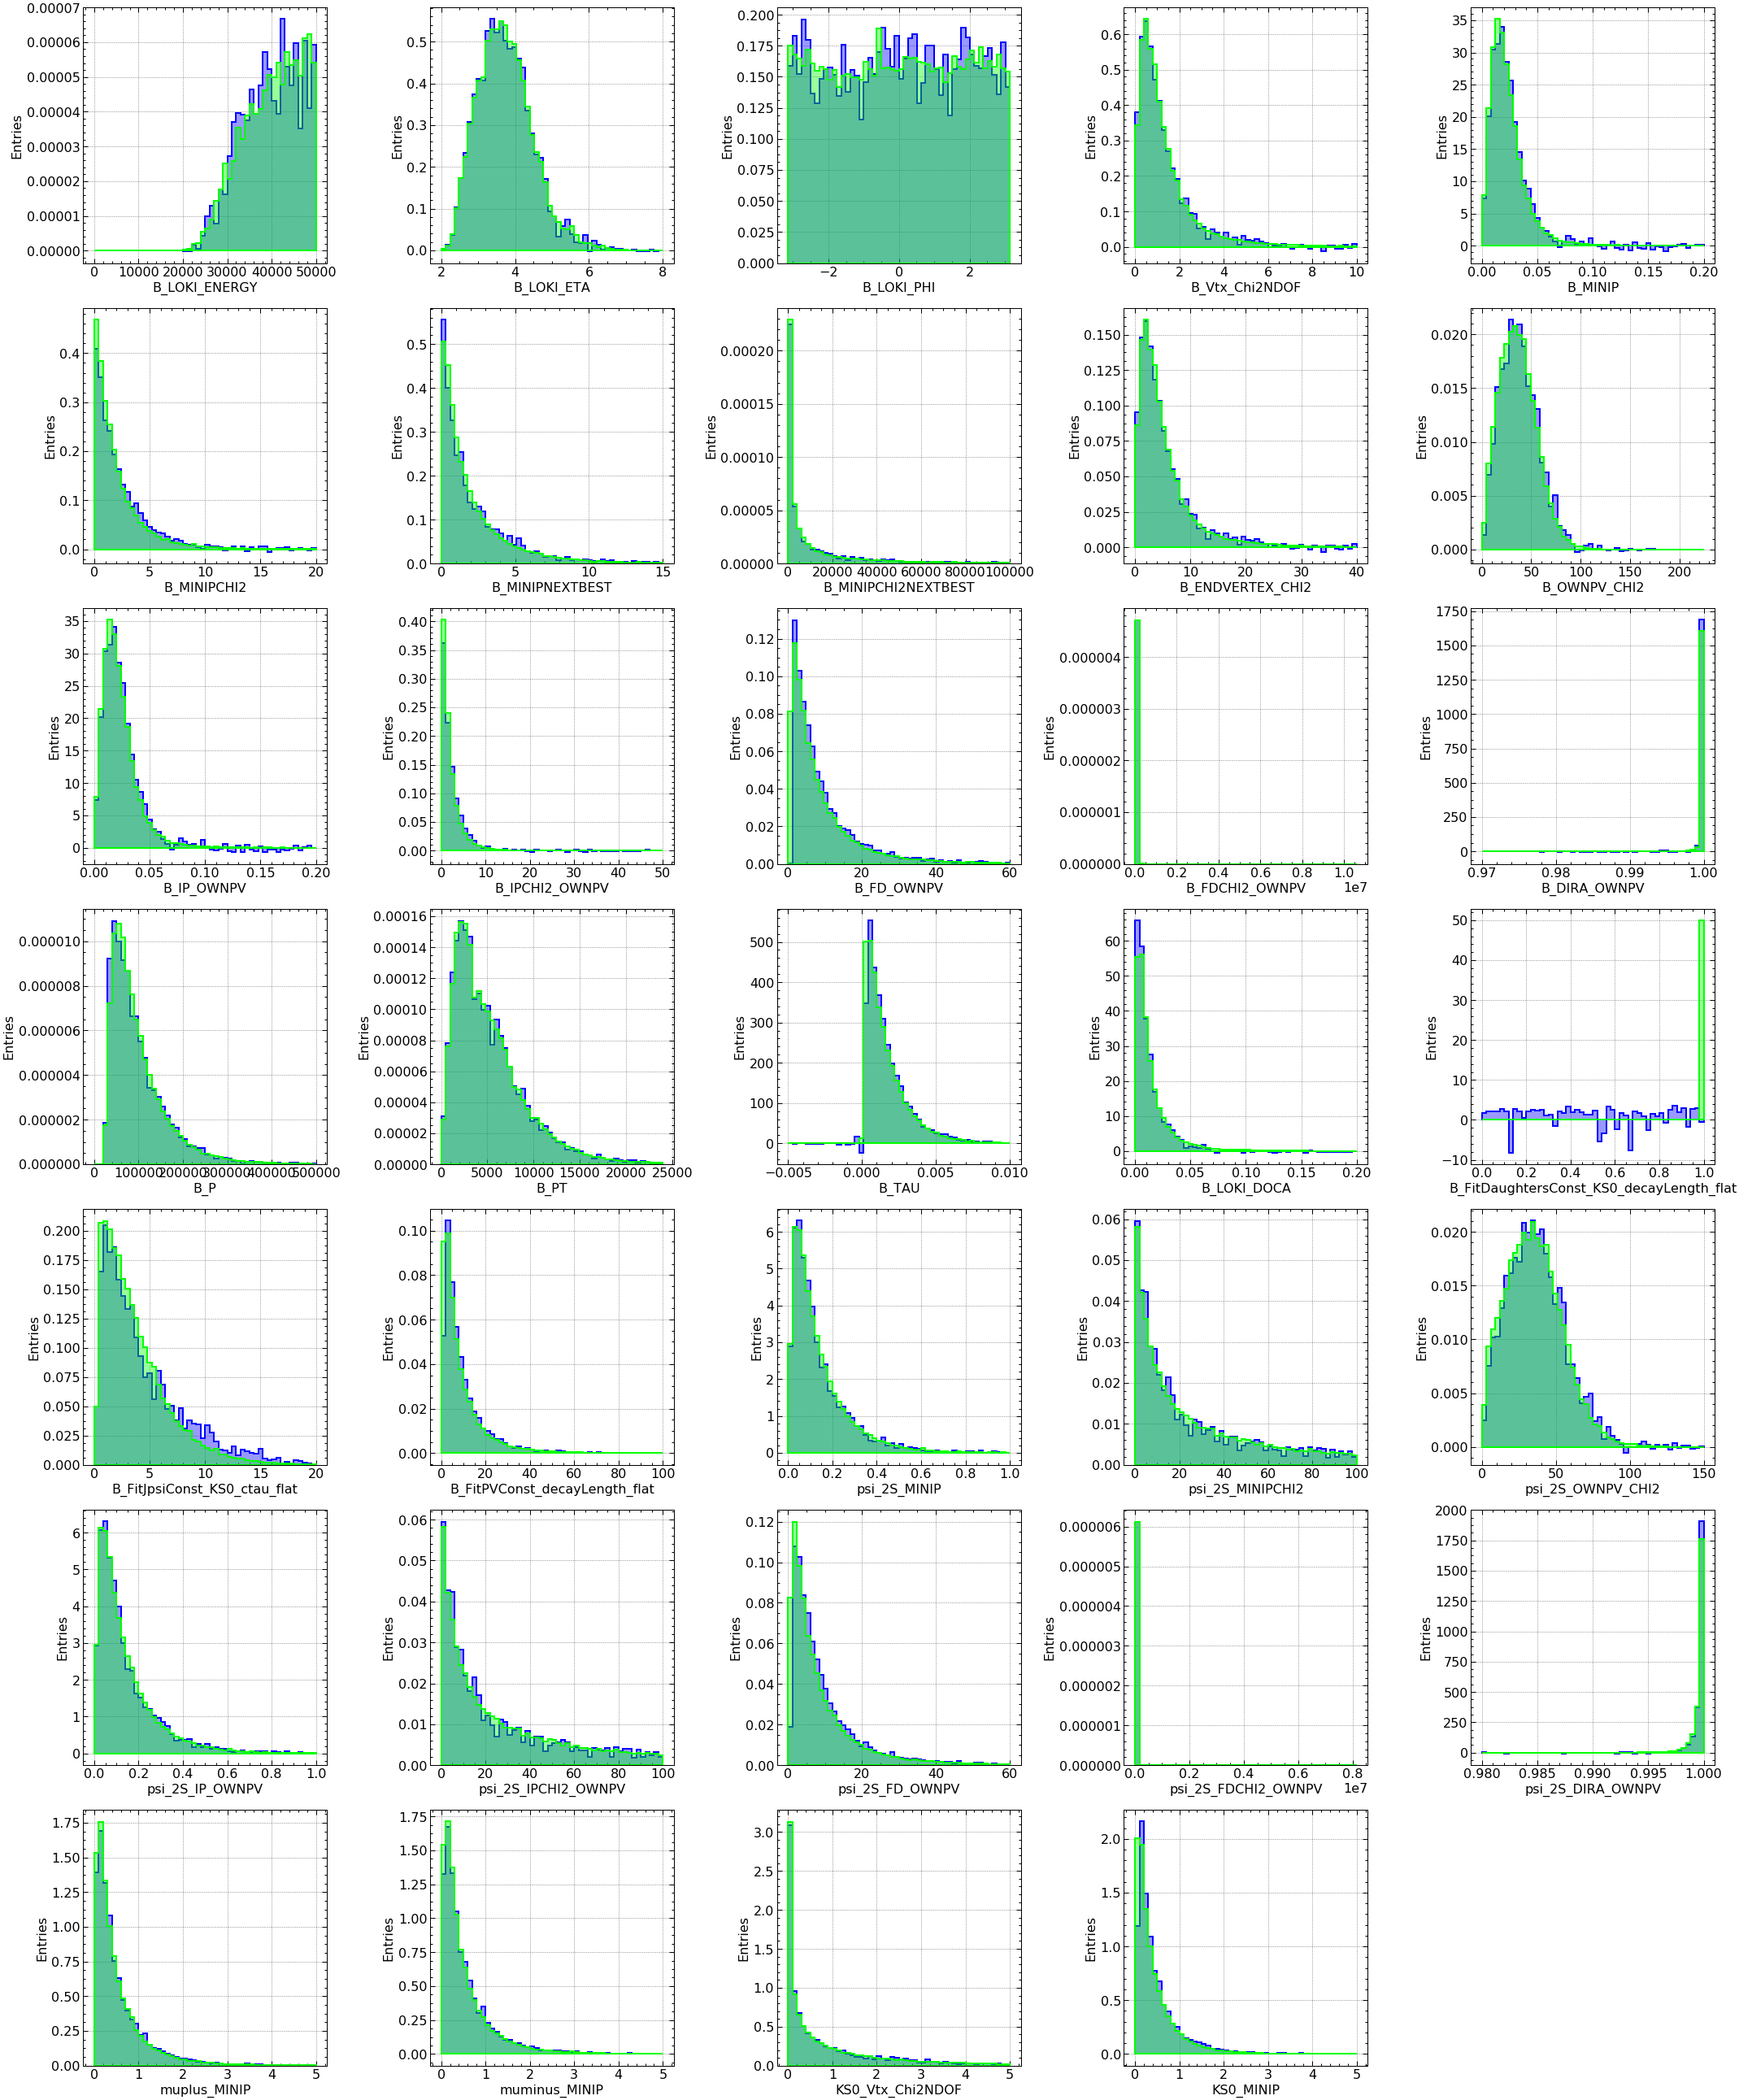

In [23]:
fig, ax = plt.subplots(7, 5, figsize=(30, 36))
fig.delaxes(ax[6,4])
n_bins = 50
ranges = [(0, 50000), (2, 8), None, None, (0, 0.2), (0, 20), (0, 15), (0, 100000), None, None, (0, 0.2), (0, 50), (0, 60),
         None, (0.97, 1), (0, 500000), (0, 24000), (-0.005, 0.01), (0.0, 0.2), (0, 1), (0, 20), (0, 100), (0, 1), (0, 100),
         (0, 150), (0, 1), (0, 100), (0, 60), None, (0.98, 1), (0, 5), (0, 5), (0, 5), (0, 5)]

for i in range(34):
    ax_temp = ax[i//5, i%5]
    
    _, bins, _ = ax_temp.hist(df_data[selected_vars[i]],
                              weights=df_data["sweights_sig"],
                              density=True,
                              facecolor=(0,0,1,0.4),
                              edgecolor=(0,0,1,1.0),
                              histtype='stepfilled',
                              bins=n_bins,
                              range=ranges[i],
                              lw=2)
    
    ax_temp.hist(df_control_sim[selected_vars[i]],
                 weights=df_control_sim["kinematic_weights"], 
                 density=True,
                 facecolor=(0,1,0,0.4),
                 edgecolor=(0,1,0,1.0),
                 histtype='stepfilled',
                 bins=bins,
                 lw=2)
    
    ax_temp.set_ylabel("Entries")
    ax_temp.set_xlabel(selected_vars[i])
    
plt.tight_layout()
if save==1: plt.savefig(path+'features'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()

## 3. Feature selection
Now we want to find a set of variables that are most suitable to identify the $B_s^0$ events in the data sample. To this end, the variables need to have two properties:
 1. Reasonable agreement between data and simulation (otherwise the classifier only learns to distinguish data from simulation instead of signal from background).
 2. Strong discrimination between signal (simulation) and background (USB).
 3. Uncorrelated to the invariant mass of the $B_s^0/B_d^0$ candidate (otherwise the decisions regarding 1. made on the control channel using sWeights may be wrong AND the fit to the $B_s^0$ invariant mass in the end may be biased).

The eventually chosen most suitable variables are called features.

**This section provides a step-by-step guide to feature selection which is perfectly fine to use. But of course you are encouraged to combine all or parts of the exercises below. There is no single best solution.**

First, we identify the variables that are well modelled in the simulation. This is similar to Ex. 2.5 but instead of comparing distributions by-eye, you should choose a more objective -- read "quantitative" -- measure.

**Ex 3.1: Determine a metric to quantify the similarity between $B_d^0$ simulation and $B_d^0$ data. Use this metric to identify variables that are not suitable for the classification because they are mis-modelled in simulation.**

In [24]:
vars = all_vars[:812]
len(vars)

812

In [25]:
vars = remove_entries_with_keywords(vars, ["ERR", "Err", "Decision", "status", "Rich", "has", "Key", "_X", "_Y", "_Z"
                                          ,"_PX", "_PY", "_PZ", "UTID", "FirstMeasurement", "History", "L0Global", 
                                          "isMuon"])
len(vars)


398

### Remove entries that are too correlated to invariant mass

In [26]:
corr = []
for var in vars:
    c = df_data["B_FitDaughtersConst_M_flat"].corr(df_data[var])
    corr.append(c)
    

In [27]:
vars = list(np.array(vars)[np.array(corr) < 0.3])
len(vars)


390

In [28]:
def weighted_ks_test(data1, data2, weights1, weights2):
    # Sort the data and weights
    data1_sorted_indices = np.argsort(data1)
    data2_sorted_indices = np.argsort(data2)
    
    data1_sorted = np.array(data1)[data1_sorted_indices]
    data2_sorted = np.array(data2)[data2_sorted_indices]
    
    weights1_sorted = np.array(weights1)[data1_sorted_indices]
    weights2_sorted = np.array(weights2)[data2_sorted_indices]
    
    # Compute the cumulative sums of the weights
    cdf1 = np.cumsum(weights1_sorted) / np.sum(weights1_sorted)
    cdf2 = np.cumsum(weights2_sorted) / np.sum(weights2_sorted)
    
    # Calculate the CDF values for all unique points in both datasets
    all_data = np.concatenate([data1_sorted, data2_sorted])
    all_unique_data = np.unique(all_data)
    
    cdf1_values = np.interp(all_unique_data, data1_sorted, cdf1, left=0, right=1)
    cdf2_values = np.interp(all_unique_data, data2_sorted, cdf2, left=0, right=1)
    
    # Compute the KS statistic
    ks_statistic = np.max(np.abs(cdf1_values - cdf2_values))
    
    return ks_statistic


In [29]:
from tqdm import tqdm

In [30]:
results = []
for var in tqdm(vars):
    result = weighted_ks_test(df_data[var], df_control_sim[var], df_data["sweights_sig"], df_control_sim["kinematic_weights"])
    results.append([var, result])
    

100%|██████████| 390/390 [01:59<00:00,  4.14it/s]


In [31]:
#np.array(results)[np.argsort(np.array(results)[:,1])]

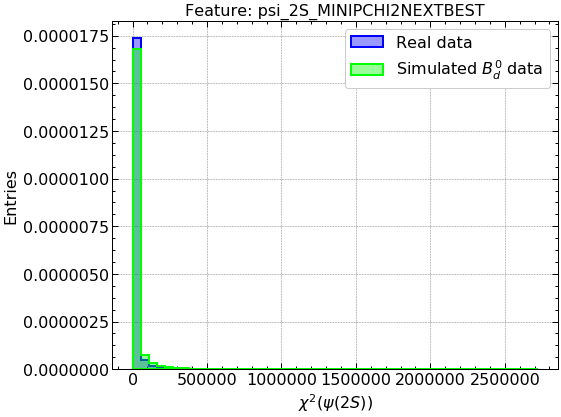

In [32]:
x = 'psi_2S_MINIPCHI2NEXTBEST'

plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist(df_data[x],
                      weights=df_data["sweights_sig"],
                      density=True,
                      facecolor=(0,0,1,0.4),
                      edgecolor=(0,0,1,1.0),
                      histtype='stepfilled',
                      bins=n_bins,
                      label='Real data',
                      lw=2)

plt.hist(df_control_sim[x],
         weights=df_control_sim["kinematic_weights"],
         density=True,
         facecolor=(0,1,0,0.4),
         edgecolor=(0,1,0,1.0),
         histtype='stepfilled',
         bins=bins,
         label='Simulated $B_d^0$ data',
         lw=2)

plt.title('Feature: psi_2S_MINIPCHI2NEXTBEST')
plt.xlabel('$\chi^2(\psi(2S))$')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

plt.tight_layout()

if save==1: plt.savefig(path+'psi_2S_MINIPCHI2NEXTBEST'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()

In [33]:
alpha = 0.95 # significance of the test

K_alpha = np.sqrt(np.log(2/alpha)/alpha)
print(f"K_alpha = {K_alpha:.6f}")
n_1 = np.sum(df_data["sweights_sig"])
n_2 = np.sum(df_control_sim["kinematic_weights"])
n = np.sqrt(n_1*n_2/(n_1+n_2))

# reject test if d > K_alpha/n
print(f"Reject if d > {K_alpha/n:.6f}")


K_alpha = 0.885224
Reject if d > 0.009022


But this choice would leave to few variables,
so we decide to **reject if d > 0.05**

In [34]:
vars = np.extract(np.array(results)[:,1].astype(float) < 0.05, np.array(results)[:,0])
len(vars)


200

Great, we are left with all variables that could help to discriminate between signal and background. The second step of feature selection is identifying the discriminatory power of each remaining variable.

**Ex. 3.2: Define a metric to quantify discriminating power and choose the best features to use in a classification algorithm.**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">This is very similar to Ex. 3.1.</a></h4>

In [35]:
results = []
for var in tqdm(vars):
    result = weighted_ks_test(bkg_sample[var], df_sim[var], np.ones(len(bkg_sample)), df_sim["kinematic_weights"])
    results.append([var, result])
    

100%|██████████| 200/200 [00:39<00:00,  7.99it/s]


In [36]:
#np.array(results)[np.argsort(np.array(results)[:,1])]

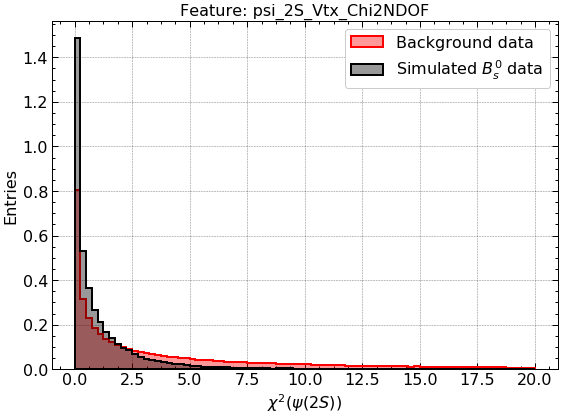

In [37]:
x = 'psi_2S_Vtx_Chi2NDOF'
xr = None
n_bins = 80

plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist(bkg_sample[x],
                      density=True,
                      facecolor=(1,0,0,0.4),
                      edgecolor=(1,0,0,1.0),
                      histtype='stepfilled',
                      bins=n_bins,
                      range=xr,
                      label='Background data',
                      lw=2)
plt.hist(df_sim[x], 
         weights=df_sim["kinematic_weights"],
         density=True,
         facecolor=(0,0,0,0.4),
         edgecolor=(0,0,0,1.0),
         histtype='stepfilled',
         bins=bins,
         label='Simulated $B_s^0$ data',
         lw=2)
         
plt.title('Feature: psi_2S_Vtx_Chi2NDOF')
plt.xlabel('$\chi^2(\psi(2S))$')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

plt.tight_layout()

if save==1: plt.savefig(path+'psi_2S_Vtx_Chi2NDOF'+format, dpi=image_save_dpi, bbox_inches='tight')


plt.show()

### Select variables with high difference between signal and background
**d > 0.20**

In [38]:
vars = np.extract(np.array(results)[:,1].astype(float) > 0.20, np.array(results)[:,0])
len(vars)


94

Now, you should have a set of variables that is well simulated and provides good discrimination between signal and background. Before we move on, you should check whether these features are uncorrelated to the invariant mass of the $B_s$ candidate.

**Ex. 3.3: Compute the correlation between your features and the invariant $B_s$ mass and remove features from your set if they are too correlated.**

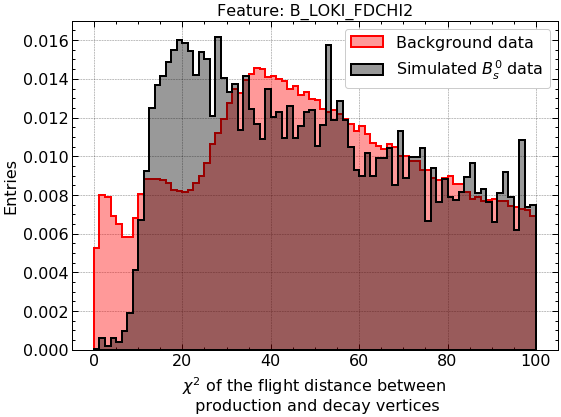

In [39]:
x = 'B_LOKI_FDCHI2'

plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist(bkg_sample[x],
                      density=True,
                      facecolor=(1,0,0,0.4),
                      edgecolor=(1,0,0,1.0),
                      histtype='stepfilled',
                      bins=n_bins,
                      range=(0, 100),
                      label='Background data',
                      lw=2)
plt.hist(df_sim[x], 
         weights=df_sim["kinematic_weights"],
         density=True,
         facecolor=(0,0,0,0.4),
         edgecolor=(0,0,0,1.0),
         histtype='stepfilled',
         bins=bins,
         label='Simulated $B_s^0$ data',
         lw=2)
         
plt.title('Feature: B_LOKI_FDCHI2')
plt.xlabel('$\chi^2$ of the flight distance between \n production and decay vertices')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

plt.tight_layout()

if save==1: plt.savefig(path+'B_LOKI_FDCHI2'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()

In [40]:
import seaborn as sns


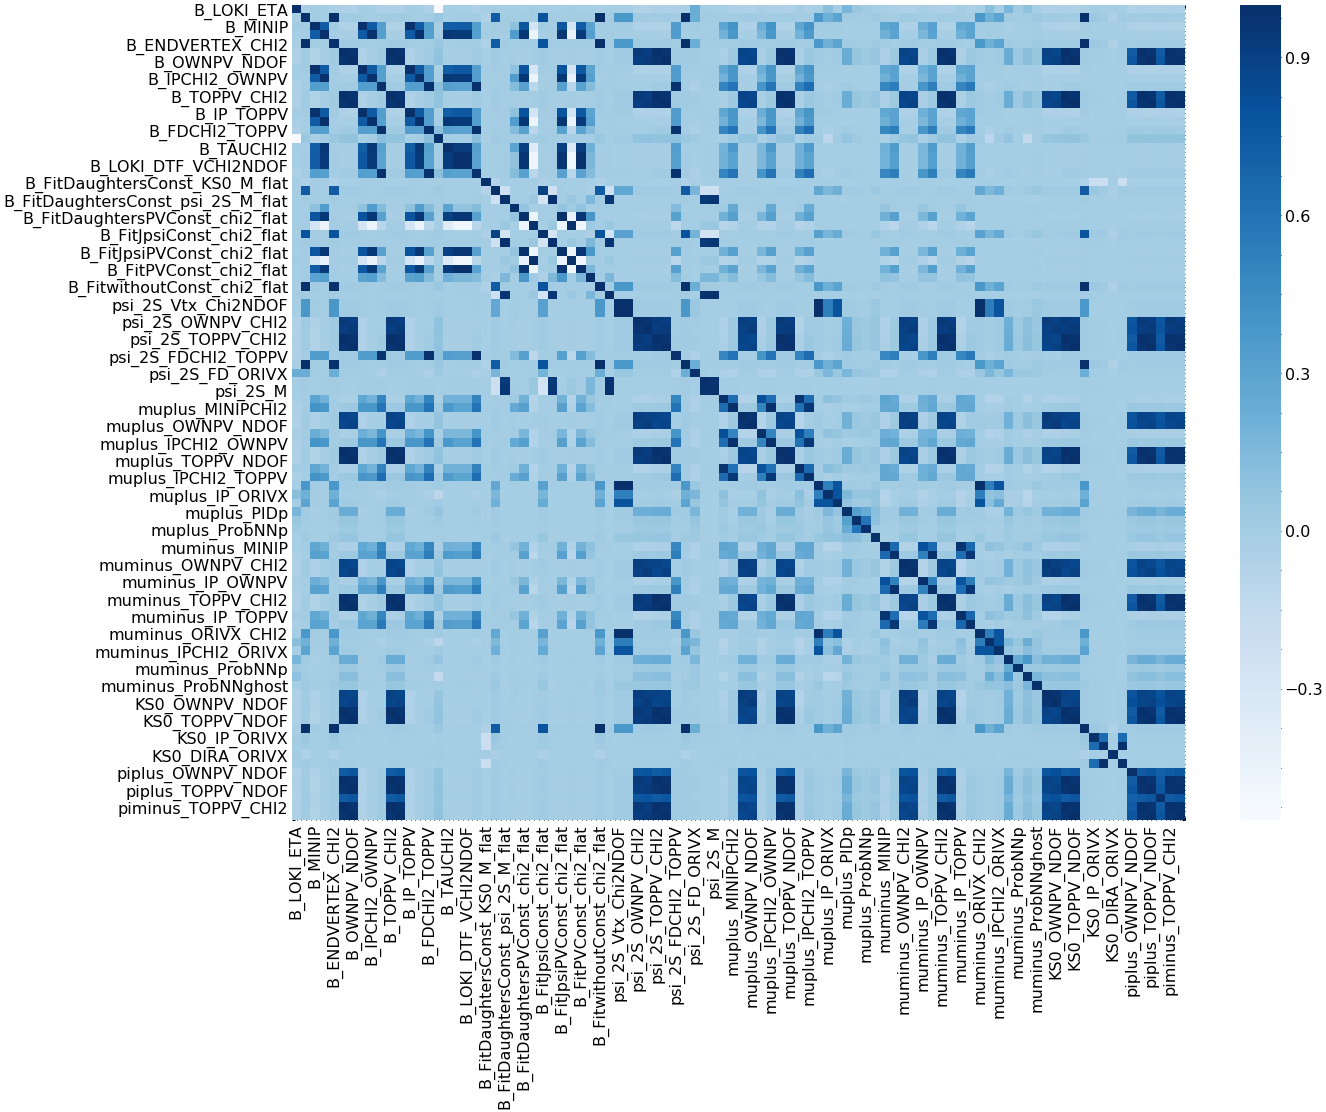

In [41]:
plt.figure(figsize=(20, 15))
cor = df_sim[vars].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Blues)

if save==1: plt.savefig(path+'corr_big'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()


### List of variables to remove (too high correlation, checking distributions by eye)

In [42]:
dublicates = ["B_ENDVERTEX_CHI2", "KS0_ORIVX_CHI2", "B_FitwithoutConst_chi2_flat", "psi_2S_ORIVX_CHI2", 
              "B_IP_OWNPV", "B_IP_TOPPV", "B_IPCHI2_OWNPV", "B_IPCHI2_TOPPV", "B_TAUCHI2", "B_LOKI_DTF_CHI2NDOF",
              "B_LOKI_DTF_VCHI2NDOF", "B_FitDaughtersPVConst_chi2_flat", "B_FitJpsiPVConst_chi2_flat", "B_FitPVConst_chi2_flat",
              "B_OWNPV_NDOF", "B_TOPPV_CHI2", "B_TOPPV_NDOF", "psi_2S_OWNPV_CHI2", "psi_2S_OWNPV_NDOF", "psi_2S_TOPPV_CHI2",
              "psi_2S_TOPPV_NDOF", "muplus_TOPPV_CHI2", "muplus_TOPPV_NDOF", "muminus_TOPPV_CHI2", "muminus_TOPPV_NDOF",
              "KS0_TOPPV_CHI2", "KS0_TOPPV_NDOF", "piplus_TOPPV_CHI2", "piplus_TOPPV_NDOF", "piminus_TOPPV_CHI2", 
              "piminus_TOPPV_NDOF", "B_FDCHI2_TOPPV", "B_LOKI_FDCHI2", "psi_2S_FDCHI2_TOPPV", "B_FitJpsiConst_psi_2S_M_flat",
              "B_FitwithoutConst_psi_2S_M_flat", "psi_2S_MM", "psi_2S_M", "psi_2S_ENDVERTEX_CHI2", "muplus_ORIVX_CHI2",
              "muminus_ORIVX_CHI2", "muplus_IP_TOPPV", "muplus_IPCHI2_OWNPV", "muplus_IPCHI2_TOPPV", "muplus_OWNPV_NDOF",
             "muminus_OWNPV_CHI2", "KS0_OWNPV_CHI2", "KS0_OWNPV_NDOF", "muminus_IP_TOPPV", "muminus_IPCHI2_OWNPV", 
             "muminus_IPCHI2_TOPPV", "KS0_TAUCHI2", "muplus_OWNPV_CHI2", "muminus_OWNPV_NDOF", "B_FitJpsiConst_chi2_flat",
             "muplus_IP_OWNPV", "muminus_IP_OWNPV", 
              # the following are optional (correlations < 0.8)
              #"B_FitDaughtersConst_chi2_flat", "B_MINIPCHI2", "piplus_OWNPV_NDOF", "piminus_OWNPV_NDOF",
              #"muplus_MINIPCHI2", "muminus_MINIPCHI2",
              # from looking at distributions
              "B_FitDaughtersPVConst_KS0_M_flat", "B_FitDaughtersConst_KS0_M_flat", "KS0_IP_ORIVX", "KS0_DIRA_ORIVX",
              "ProbNN", "psi_2S_Vtx_Chi2NDOF", "KS0_IPCHI2_ORIVX","muplus_IPCHI2_ORIVX", "muminus_IPCHI2_ORIVX", 
              "psi_2S_FD_ORIVX"
             ]

vars = remove_entries_with_keywords(vars, dublicates)
len(vars)

18

In [43]:
pd.set_option("max_rows", 15)
pd.set_option("max_columns", 10)
cor

,B_LOKI_ETA,B_Vtx_Chi2NDOF,B_MINIP,B_MINIPCHI2,B_ENDVERTEX_CHI2,...,piplus_TOPPV_CHI2,piplus_TOPPV_NDOF,piminus_OWNPV_NDOF,piminus_TOPPV_CHI2,piminus_TOPPV_NDOF
B_LOKI_ETA,1.000000,-0.018571,0.007175,-0.009062,-0.018571,...,-0.039810,-0.045546,-0.055700,-0.039810,-0.045546
B_Vtx_Chi2NDOF,-0.018571,1.000000,0.012938,-0.000459,1.000000,...,0.016938,0.016936,0.015799,0.016938,0.016936
B_MINIP,0.007175,0.012938,1.000000,0.741416,0.012938,...,-0.054629,-0.057395,-0.044872,-0.054629,-0.057395
B_MINIPCHI2,-0.009062,-0.000459,0.741416,1.000000,-0.000459,...,-0.012293,-0.011724,-0.006153,-0.012293,-0.011724
B_ENDVERTEX_CHI2,-0.018571,1.000000,0.012938,-0.000459,1.000000,...,0.016938,0.016936,0.015799,0.016938,0.016936
B_OWNPV_CHI2,-0.039810,0.016938,-0.054629,-0.012293,0.016938,...,1.000000,0.972184,0.744172,1.000000,0.972184
B_OWNPV_NDOF,-0.045546,0.016936,-0.057395,-0.011724,0.016936,...,0.972184,1.000000,0.772538,0.972184,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
KS0_TAUCHI2,-0.000293,0.018549,-0.000055,-0.000147,0.018549,...,0.001920,0.002029,0.000601,0.001920,0.002029
piplus_OWNPV_NDOF,-0.055908,0.013198,-0.044856,-0.005958,0.013198,...,0.743497,0.771738,0.709113,0.743497,0.771738


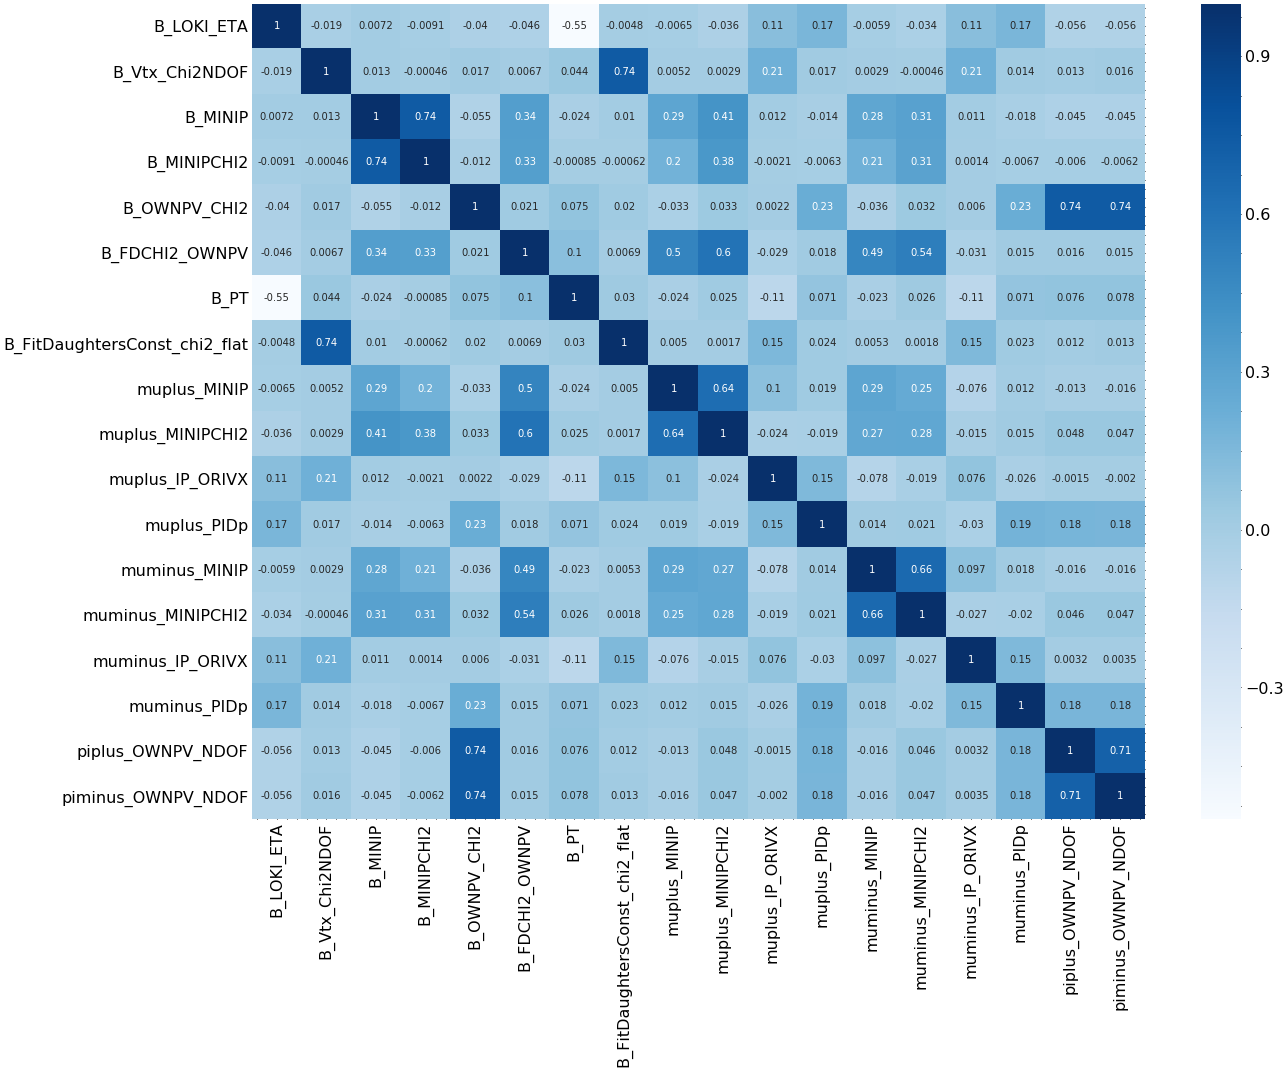

In [44]:
plt.figure(figsize=(20, 15))
cor = df_sim[vars].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

if save==1: plt.savefig(path+'corr'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()

### Check leftover variables again via plot

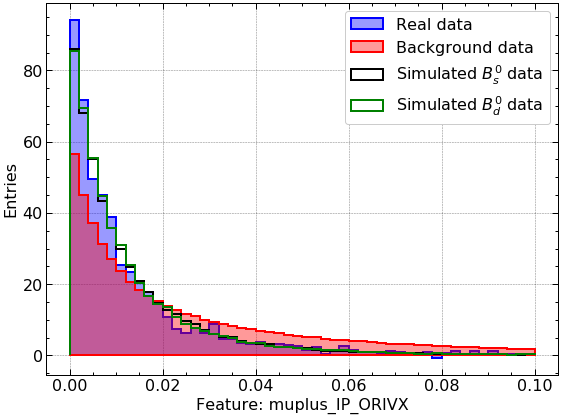

51

In [45]:
x = 'muplus_IP_ORIVX'

plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist(df_data[x],
                      bins=50,
                      weights = df_data["sweights_sig"],
                      density=True,
                      facecolor=(0,0,1,0.4),
                      edgecolor=(0,0,1,1.0),
                      histtype='stepfilled',
                      range=(0, 0.1),
                      label='Real data',
                      lw = 2)

plt.hist(bkg_sample[x],
         bins=bins,
         density=True,
         facecolor=(1,0,0,0.4),
         edgecolor=(1,0,0,1.0),
         histtype='stepfilled',
         label='Background data',
         lw = 2)

plt.hist(df_sim[x],
         bins=bins,
         weights=df_sim["kinematic_weights"],
         density=True,
         alpha=1,
         color='k',
         histtype='step',
         label='Simulated $B_s^0$ data',
         lw = 2)

plt.hist(df_control_sim[x],
         bins=bins,
         weights=df_control_sim["kinematic_weights"],
         density=True,
         alpha=1,
         color='g',
         histtype='step',
         label='Simulated $B_d^0$ data',
         lw = 2)

plt.xlabel('Feature: muplus_IP_ORIVX')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

plt.tight_layout()

if save==1: plt.savefig(path+'muplus_IP_ORIVX'+format, dpi=image_save_dpi, bbox_inches='tight')

plt.show()
len(bins)

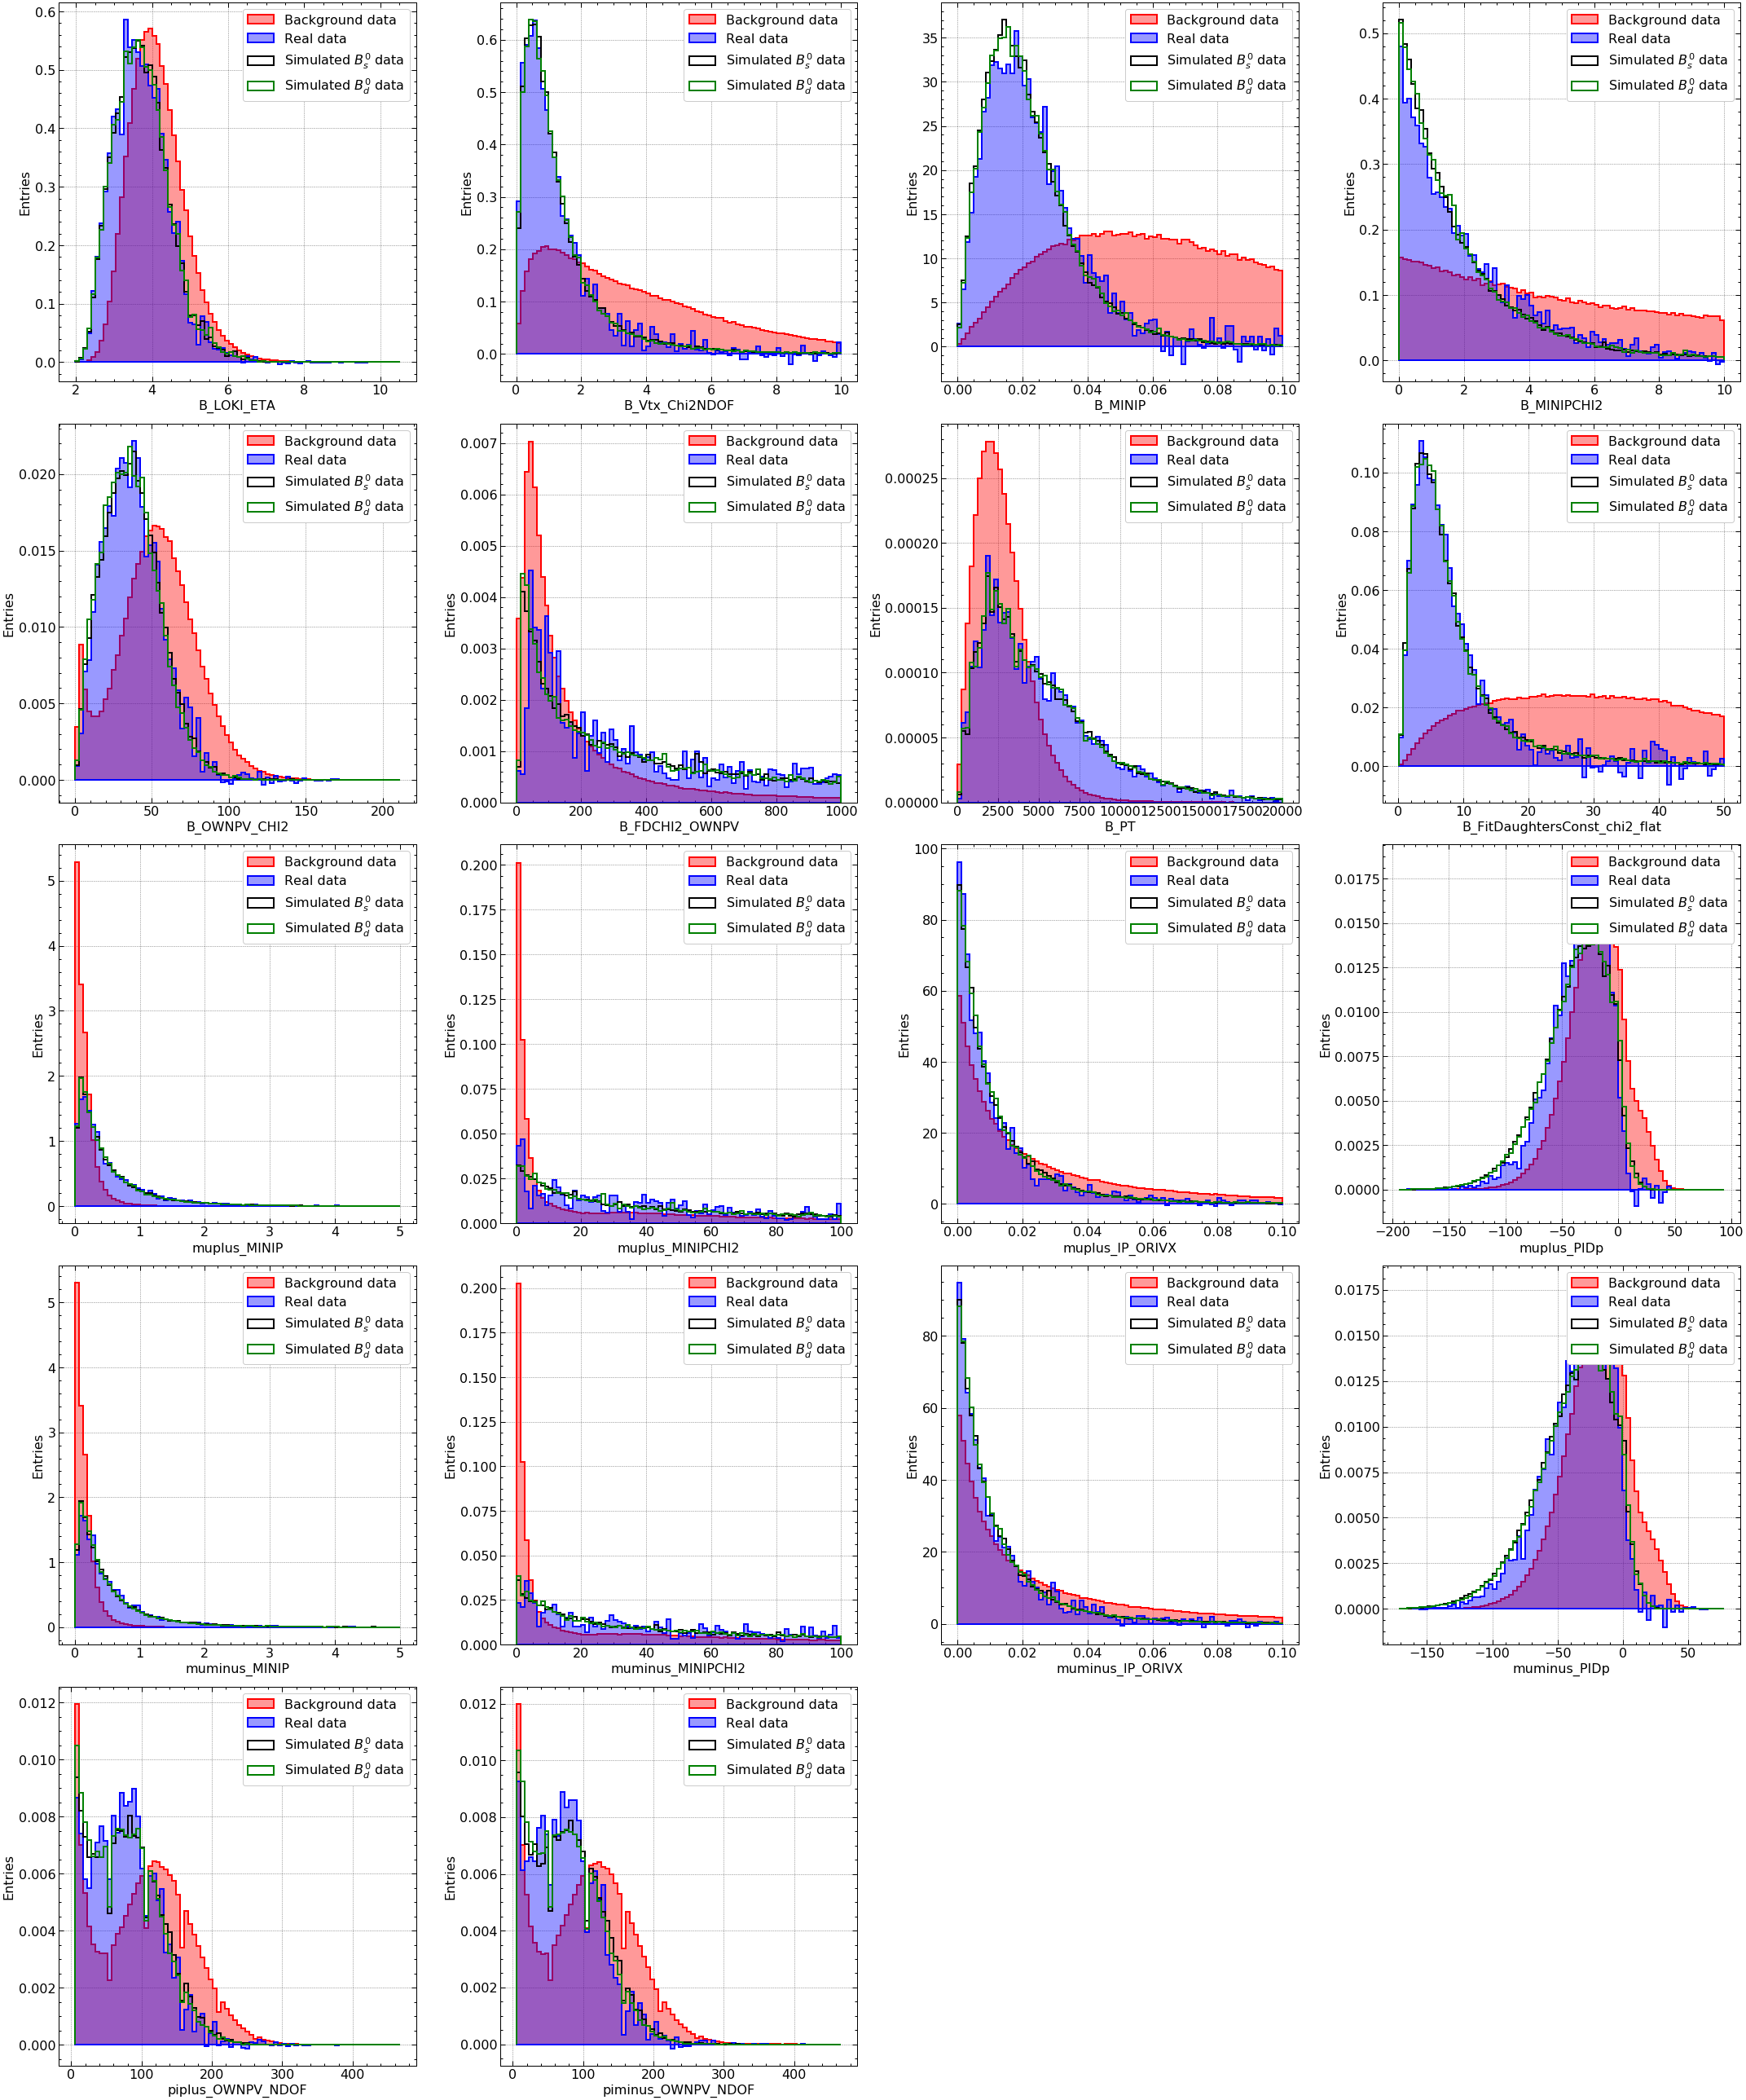

In [46]:
fig, ax = plt.subplots(5, 4, figsize=(30, 36))
fig.delaxes(ax[4,2])
fig.delaxes(ax[4,3])
n_bins = 80
ranges = [None, None, (0, 0.1), (0, 10), None, (0, 1000), (0, 20000), None, (0, 5), (0, 100), (0,0.1), None, 
          (0, 5), (0, 100), (0,0.1), None, None, None]
for i in range(len(vars)):
    ax_temp = ax[i//4, i%4]
    
    _, bins, _ = ax_temp.hist(bkg_sample[vars[i]],
                              density=True,
                              bins=n_bins,
                              facecolor=(1,0,0,0.4),
                              edgecolor=(1,0,0,1.0),
                              range=ranges[i],
                              histtype="stepfilled", 
                              label="Background data",
                              lw=2)
    
    ax_temp.hist(df_data[vars[i]],
                 density=True,
                 bins=bins,
                 facecolor=(0,0,1,0.4),
                 edgecolor=(0,0,1,1.0),
                 weights=df_data["sweights_sig"],
                 histtype="stepfilled", 
                 label="Real data",
                 lw=2)
    
    ax_temp.hist(df_sim[vars[i]],
                 weights=df_sim["kinematic_weights"],
                 density=True,
                 alpha=1,
                 bins=bins,
                 color='k',
                 histtype="step", 
                 label="Simulated $B_s^0$ data",
                 lw = 2)
    
    ax_temp.hist(df_control_sim[vars[i]],
                 weights=df_control_sim["kinematic_weights"],
                 density=True,
                 alpha=1,
                 bins=bins,
                 color='g',
                 histtype="step",
                 label="Simulated $B_d^0$ data",
                 lw = 2)
    
    ax_temp.set_ylabel("Entries")
    ax_temp.set_xlabel(vars[i])
    ax_temp.legend()

plt.tight_layout()
if save==1: plt.savefig(path+'features2'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()


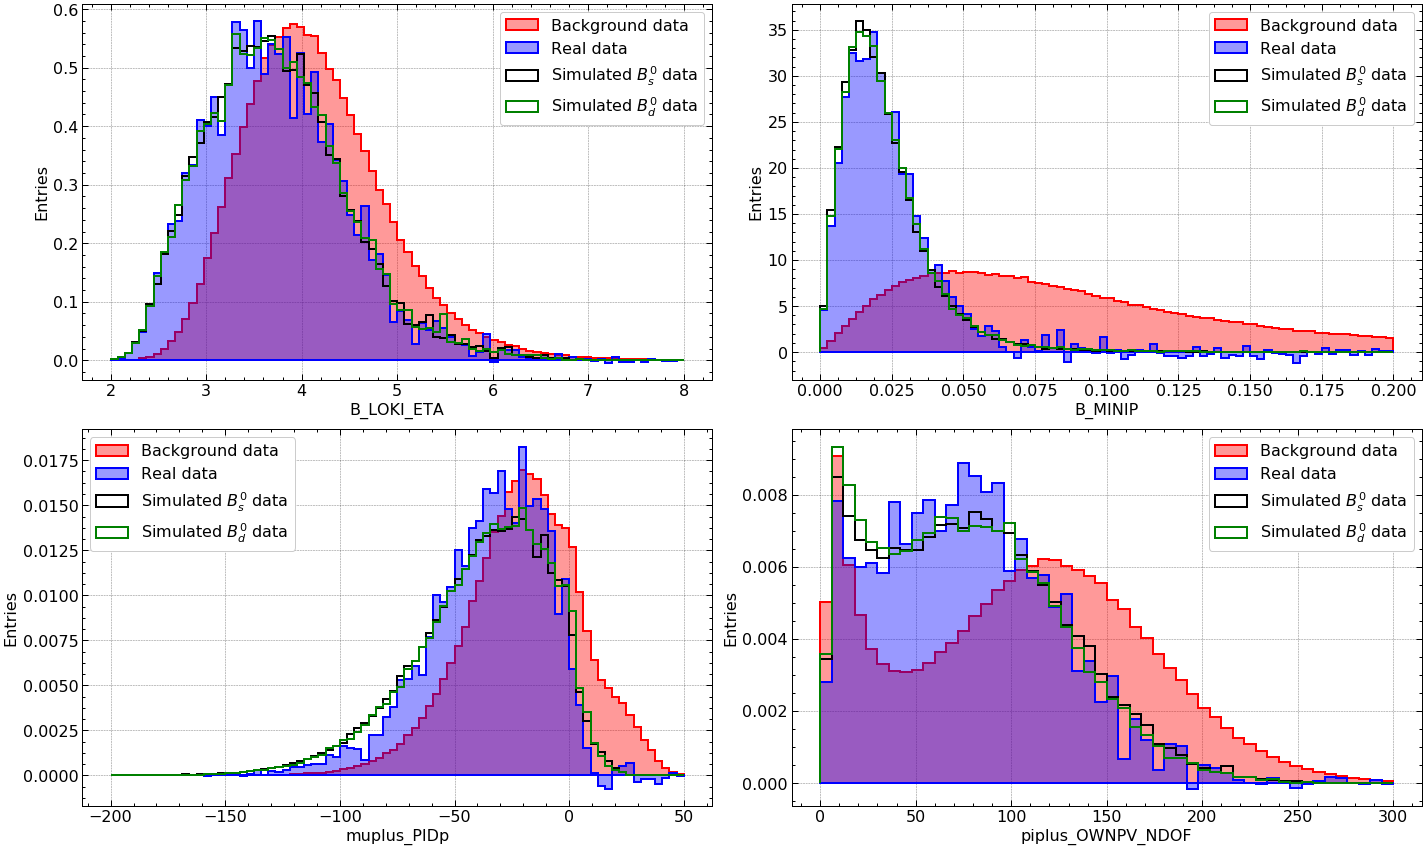

In [47]:
fig, ax = plt.subplots(2, 2, figsize = (20, 12))
v = ["B_LOKI_ETA", "B_MINIP", "muplus_PIDp", "piplus_OWNPV_NDOF"]
ranges = [(2, 8), (0, 0.2), (-200, 50), (0, 300)]
n_bins = [80, 80, 80, 50]

for i in range(4):
    ax_temp = ax[i//2, i%2]
    
    _, bins, _ = ax_temp.hist(bkg_sample[v[i]],
                              density=True,
                              bins=n_bins[i],
                              facecolor=(1,0,0,0.4),
                              edgecolor=(1,0,0,1.0),
                              range=ranges[i], 
                              histtype="stepfilled",
                              label="Background data",
                              lw=2)
        
    ax_temp.hist(df_data[v[i]],
                 density=True,
                 bins=bins,
                 facecolor=(0,0,1,0.4),
                 edgecolor=(0,0,1,1.0),
                 weights=df_data["sweights_sig"],
                 histtype="stepfilled", 
                 label="Real data",
                 lw=2)
    
    ax_temp.hist(df_sim[v[i]],
                 weights=df_sim["kinematic_weights"],
                 density=True,
                 alpha=1,
                 bins=bins,
                 color='k',
                 histtype="step",
                 label="Simulated $B_s^0$ data",
                 lw=2)
    
    ax_temp.hist(df_control_sim[v[i]],
                 weights=df_control_sim["kinematic_weights"],
                 density=True,
                 alpha=1,
                 bins=bins,
                 color='g',
                 histtype="step",
                 label="Simulated $B_d^0$ data",
                 lw=2)
    
    ax_temp.set_ylabel("Entries")
    ax_temp.set_xlabel(v[i])
    ax_temp.legend()

ax[1,0].legend(loc='upper left')
plt.tight_layout()
if save==1: plt.savefig(path+'features3'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()


In [48]:
vars

['B_LOKI_ETA',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_OWNPV_CHI2',
 'B_FDCHI2_OWNPV',
 'B_PT',
 'B_FitDaughtersConst_chi2_flat',
 'muplus_MINIP',
 'muplus_MINIPCHI2',
 'muplus_IP_ORIVX',
 'muplus_PIDp',
 'muminus_MINIP',
 'muminus_MINIPCHI2',
 'muminus_IP_ORIVX',
 'muminus_PIDp',
 'piplus_OWNPV_NDOF',
 'piminus_OWNPV_NDOF']

## 4. Training a classification algorithm!

Now we have everything we need to train our classification algorithm. Awesome!

**Again, this section is a rather close guide to training a BDT. As before, feel free to ignore the exercises and define a classification algorithm deviating from the help provided. If you are feeling especially curious, try out other binary classification algorithms too.**

I suggest to use the [XGBoost](https://github.com/dmlc/xgboost) implementation of a [Boosted](https://en.wikipedia.org/wiki/Gradient_boosting) [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) for starters.

A BDT is a [supervised learning algorithm](https://en.wikipedia.org/wiki/Supervised_learning). This means that it needs to know to which category its input truely belongs. Therefore, we need to define labels for each event. The proposed implementation of a BDT takes an array of training samples and a list containing the corresponding label. 

**Ex 4.1: Define training sample and labels**

In [49]:
mask_sig_low = df_sim["B_FitDaughtersConst_M_flat"]> min_int[0]
mask_sig_high = df_sim["B_FitDaughtersConst_M_flat"]<min_int[1]
mask_sig = mask_sig_low&mask_sig_high
signal = df_sim[mask_sig].copy()
label_sig = np.ones(len(signal))
weights_sig = signal["kinematic_weights"]

There is way more entries in our background sample than in the signal simulation. If these numbers are too unbalanced, classification algorithms may run into problems. Consider for instance a training set with 99% background. By simply classifiying the entire sample as background, the algorithm achieves 99% accuracy. That's not very useful.
Therefore, we assign a weight to each background event to make them "less important" in the training, while still taking advantage of the full backround sample.

**Ex 4.2: Define suitable weights for the background sample**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">50/50 is never a bad choice.</a></h4>

In [50]:
weight = len(signal)/len(bkg_sample)
print('signal:',len(signal))
print('bkg_sample:',len(bkg_sample))
print('weight:',weight)
label_background = np.zeros(len(bkg_sample))
weights_background = np.full(len(bkg_sample), weight)

signal: 211314
bkg_sample: 643816
weight: 0.3282211066515899


The array of (signal and background) training samples is called `training_samples`, the list of labels is called `training_labels`, and the weights for each event is contained in the list `training_events`.

In order to avoid overtraining, we want split the data to train the classifier on one part and classify
only the "unseen" part. Since we do not want to "waste" any data just for testing,
we [cross-validate](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) using the implementation in `sklearn.model_selection.StratifiedKFold`.

**Make sure that you always apply the right BDT to the right training sample (the one you trained it on)!**

**Ex 4.3: Define a folding and train one BDT per fold, training on $\frac{n-1}{n}$ and testing on $\frac{1}{n}$ of the training data**

As usual a plot can give you a quick idea of what you are doing is correct.

**Ex 4.4: Plot the distribution of the BDT output for the singal and background samples to visualize the classification.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Make sure to apply the right BDT to the right sample. And a logarithmic scale may be useful again.
</a></h4>

Now that our model consisting of $n$ BDTs is trained, we want to check how well it did! As metric we choose to look at the [Reciever-Operating-Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under its curve.

**Ex 4.5: Evaluate the performance of your classifier by plotting the ROC curve and calculating the area under the curve for every BDT you trained. Do not evaluate the signal region of the data yet.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Make sure you apply the right BDt to the right sample. Check out `sklearn` for an implementation of the ROC curve.
</a></h4>

In [51]:
import uncertainties as unc
import uncertainties.unumpy as unp
from uncertainties import ufloat

def eval_clf(clf, X_test, y_test, name, i):
    
    if not isinstance(clf, list):
        clf = [clf]
    
    fig = plt.figure(figsize=(20, len(clf)*8))
    grid = fig.add_gridspec(nrows =len(clf), ncols= 2)

    for clf, id in zip(clf, range(len(clf))):
        preds_proba = clf.predict_proba(X_test)
        preds = clf.predict(X_test)
        fpr, tpr, t = roc_curve(y_test, preds_proba[:,1])

        ax = fig.add_subplot(grid[id, 0])
        
        label = name
        if label != None:
            if not isinstance(label, list):
                label = [label]
            ax.set_title(label[id])

        sc = ax.scatter(fpr, tpr, c=t, cmap='summer', s=50)
        #cb = plt.colorbar(sc, label='', ax = ax)
        cb = plt.colorbar(sc, ax = ax)
        cb.set_label('Decision Threshold', rotation=90, labelpad=15)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate');
        ax.text(0.5, 0.90, f"AUC:      ${roc_auc_score(y_test, preds_proba[:,1]):.4f}$", fontsize = 12)
        ax.text(0.5, 0.82, f"Accuracy: ${accuracy_score(y_test, preds):.4f}$", fontsize = 12);
        ax.text(0.5, 0.74, f"Recall:   ${recall_score(y_test, preds):.4f}$", fontsize = 12);
        #ax.text(0.5, 0.66, f"F1:       ${f1_score(y_test, preds):.4f}$", fontsize = 18);

        print(label[id])
        print("roc_auc score:  ", roc_auc_score(y_test, preds_proba[:,1]))
        print("Accuracy:       ", accuracy_score(y_test, preds))
        print("Recall:         ", recall_score(y_test, preds))
        print("\n")

        cm = confusion_matrix(y_test, preds)

        subax = fig.add_subplot(grid[id, 1])

        vmin = cm.min()
        vmax = cm.max()

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="summer",
            xticklabels=["background", "signal"],
            yticklabels=["background", "signal"],
            ax=subax,
            vmin=vmin,
            vmax=vmax,
            annot_kws={"size": 24},
            cbar_kws={'label': 'Counts'}
        )
        subax.set_ylabel("Actual")
        subax.set_xlabel("Predicted") 
        subax.set_title("Confusion Matrix")
        
        plt.tight_layout()
        if save==1: plt.savefig(path+'clf'+ str(i)+format, dpi=image_save_dpi, bbox_inches='tight')
        plt.show()

def train_test(clf, X_train, X_test, y_train, y_test, name, i):
    preds_proba_train =clf.predict_proba(X_train)
    preds_proba_test =clf.predict_proba(X_test)

    bins = np.linspace(0, 1, 51)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1])/ len(centers)

    fig = plt.figure(figsize = (9, 6))
    ax = fig.subplots(1, 1)

    ax.hist(preds_proba_train[:,1][y_train == 1], bins = bins, facecolor=(0,1,0,0.4), label = "Signal (training)", density = True, edgecolor=(0,1,0,1), lw = 2);
    ax.hist(preds_proba_train[:,1][y_train == 0], bins = bins, facecolor=(1,0,0,0.4), label = "Background (training)", density = True, edgecolor=(1,0,0,1), lw = 2);

    counts, _ = np.histogram(preds_proba_test[:,1][y_test == 1], bins = bins, density = False)
    counts = unp.uarray(counts, np.sqrt(counts))
    counts_norm = counts/(len(preds_proba_test[:,1][y_test == 1])*width)

    ax.errorbar(centers, unp.nominal_values(counts_norm), unp.std_devs(counts_norm), lw = 0, elinewidth= 1, color = "g", marker = ".", markersize=10, label = "Signal (test)")

    counts, _ = np.histogram(preds_proba_test[:,1][y_test == 0], bins = bins, density = False)
    counts = unp.uarray(counts, np.sqrt(counts))
    counts_norm = counts/(len(preds_proba_test[:,1][y_test == 0])*width)

    ax.errorbar(centers, unp.nominal_values(counts_norm), unp.std_devs(counts_norm), lw = 0, elinewidth= 1, color = "r", marker = ".", markersize=10, label = "Background (test)")

    ax.set_ylabel("Entries")
    ax.set_xlabel("BDT classification")
    ax.set_title(name)
    ax.grid()

    ax.legend(loc=9, frameon=True,facecolor="white",framealpha = 1);

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()+ ax.get_legend().get_texts()):
        item.set_fontsize(20)
    ax.yaxis.offsetText.set_fontsize(20)
    
    plt.tight_layout()
    if save==1: plt.savefig(path+'train_test'+ str(i)+format, dpi=image_save_dpi, bbox_inches='tight')
    plt.show()
        

In [52]:
X = pd.concat([signal[vars], bkg_sample[vars]])
y = np.concatenate([label_sig, label_background])
weights_BDT = np.concatenate([weights_sig, weights_background])

from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

#X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights_BDT, test_size=0.2, random_state=69)
#from xgboost import XGBClassifier
#bdt = XGBClassifier()
#bdt.fit(X_train,y_train,sample_weight = weights_train)


Fold:  1
XGBClassifier 1
roc_auc score:   0.9957067252806828
Accuracy:        0.9711330440985582
Recall:          0.9663298866620922




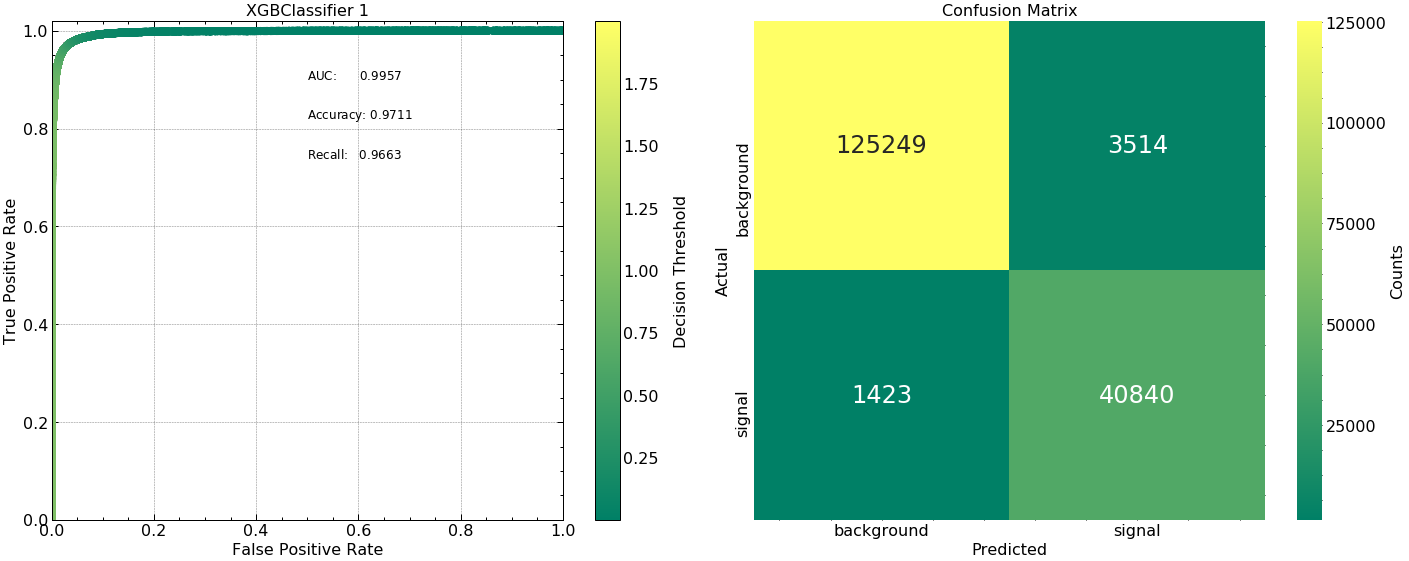

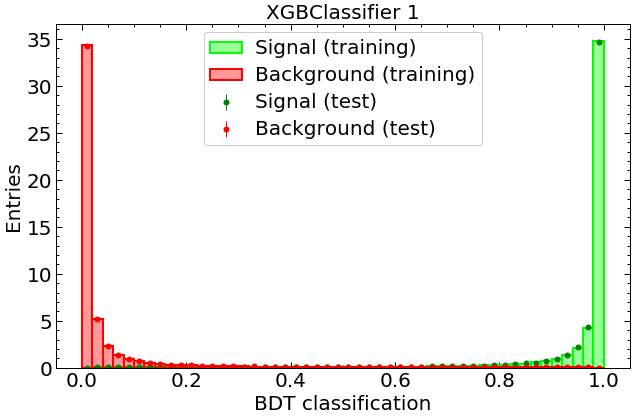

Fold:  2
XGBClassifier 2
roc_auc score:   0.9955162790269609
Accuracy:        0.9710219498789657
Recall:          0.9659276435652935




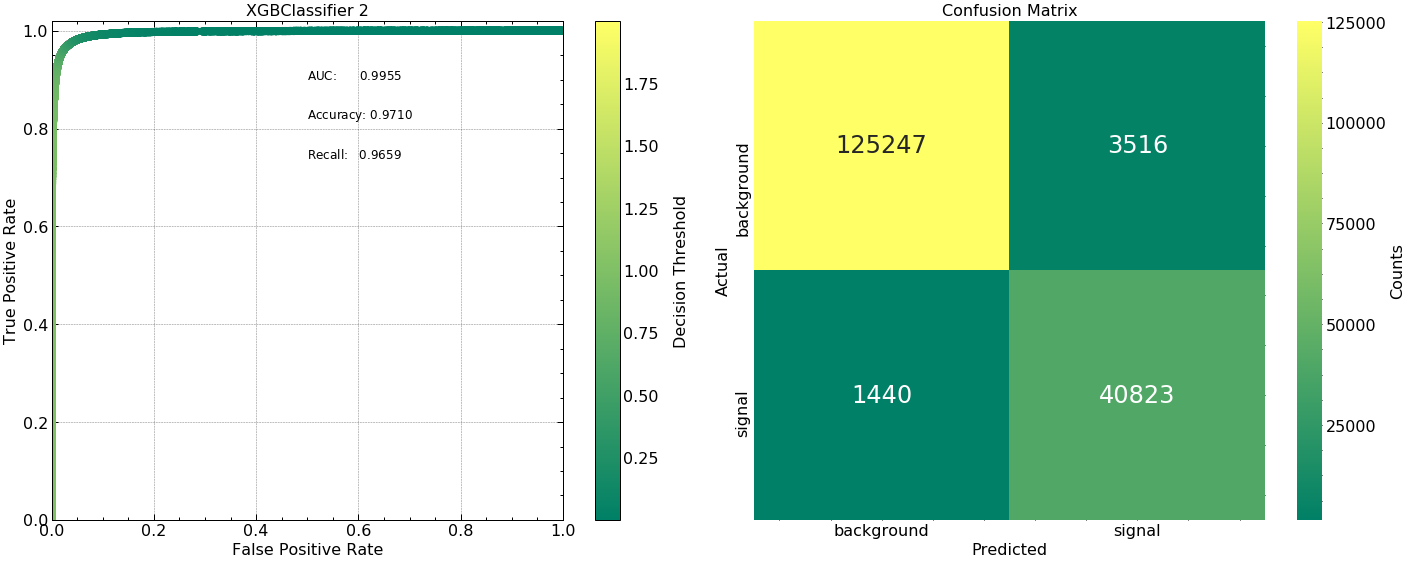

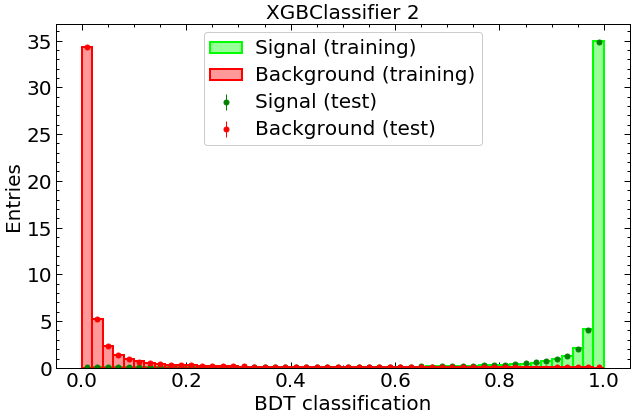

Fold:  3
XGBClassifier 3
roc_auc score:   0.995514124269062
Accuracy:        0.9711388911627472
Recall:          0.965194141447602




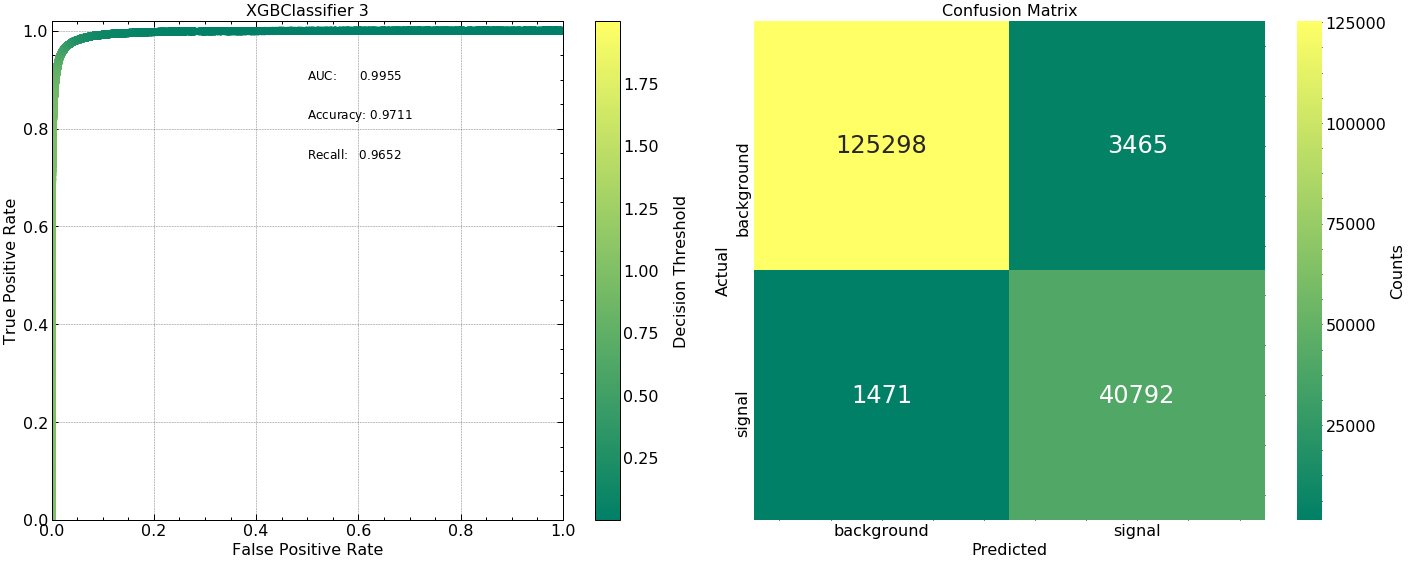

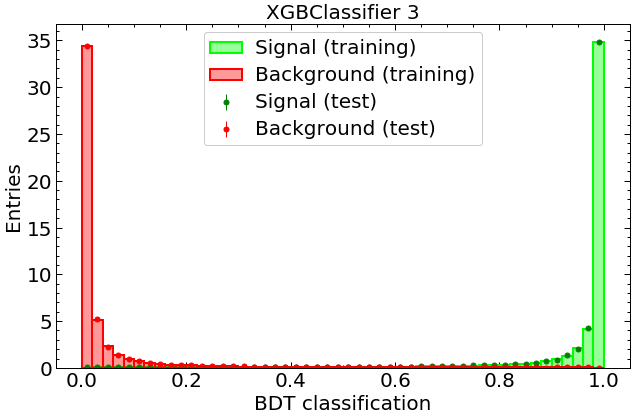

Fold:  4
XGBClassifier 4
roc_auc score:   0.9956771295173937
Accuracy:        0.9709985616222095
Recall:          0.9656910299789414




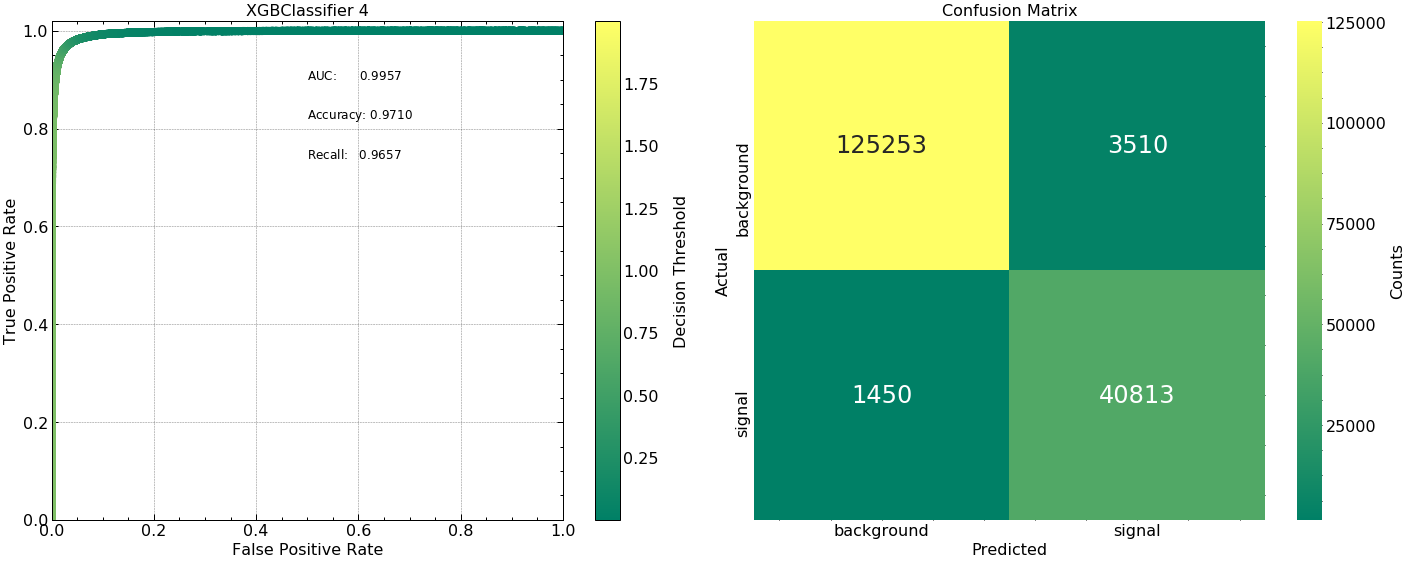

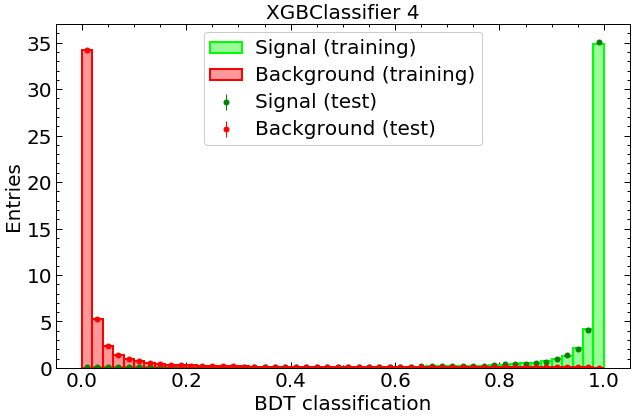

Fold:  5
XGBClassifier 5
roc_auc score:   0.9955420949389262
Accuracy:        0.9703203021762773
Recall:          0.9651459940371966




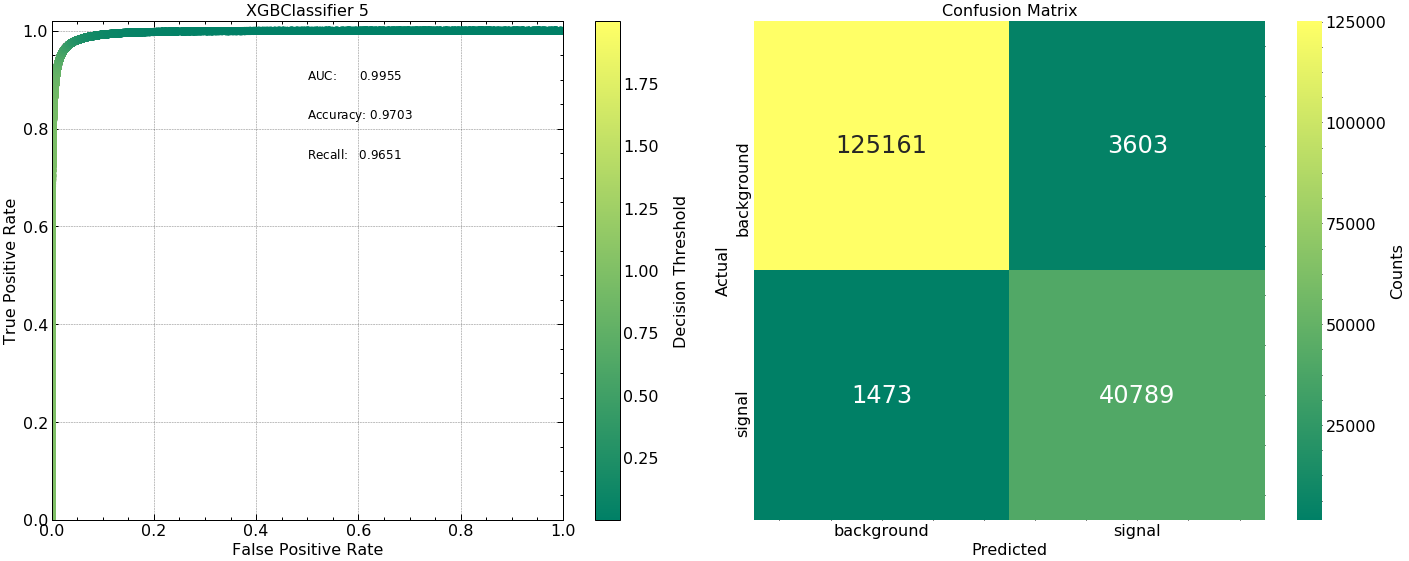

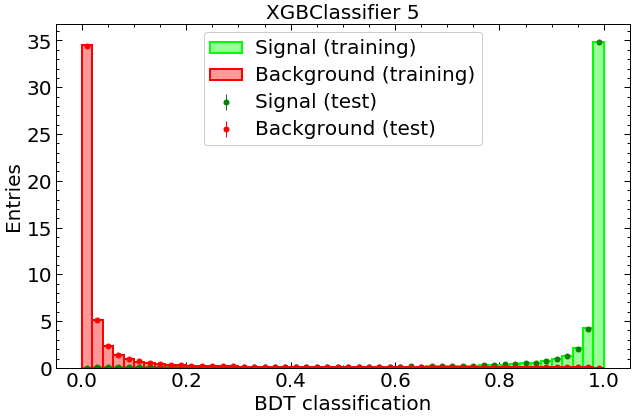

In [53]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 42)
clf_list = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):

    print("Fold: ", i+1)

    X_train = X[vars].iloc[train_index]
    X_test = X[vars].iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    weights = weights_BDT[train_index]
    
    bdt = XGBClassifier()
    bdt.fit(X_train, y_train, sample_weight = weights)
    eval_clf(bdt, X_test, y_test, f"XGBClassifier {i+1}",i)
    train_test(bdt, X_train, X_test, y_train, y_test, f"XGBClassifier {i+1}",i)
    clf_list.append(bdt)

## 5. Classification threshold optimization
Now that we have our predictions, we would like to define a value at which we split the datasets into signal and background. We go with the following definition of a measure for signal sensitivity/significance:   
$s = \frac{\epsilon_{sig}}{5/2 + \sqrt{n_{bkg}}}$,  
where $\epsilon_{sig}$ is the efficiency of our selection regarding signal and $n_{bkg}$ is the number of background events in the signal region.

We compute the significance for several possible splitting points from 0 to 1. Eventually, we choose the cut-off leading to the highest significance.

First though, we need to compute the signal efficiency and number of background events in the signal region serving as input to our FOM.

**Ex 5.1: Find a way to estimate the signal efficiency and the number of background events in the signal region(!) depending on the cut on the BDT output.**

In [54]:
from iminuit import cost, Minuit
from scipy.stats import truncnorm, norm, expon, truncexpon#, crystalball_ex
from scipy.integrate import quad

In [55]:
fit_range = (5100, 6000)

def background_model(x, b, tau):
    return b, b * truncexpon.pdf(x, b=(fit_range[1]-fit_range[0])/tau, loc=fit_range[0], scale=tau)

def efficiency(df, cut):
    return len(df[df["BDT_pred"] >= cut])/len(df)

def get_background(df, cut, window):
    mask = df["BDT_pred"] >= cut
    X = df[mask]["B_FitDaughtersConst_M_flat"]

    if len(X) == 0:
        return 0
    
    c = cost.ExtendedUnbinnedNLL(X, background_model)

    m = Minuit(c, b = len(X), tau=200)
    m.limits["b"] = (1, len(X)+1e3)
    m.limits["tau"] = (0, None)
    
    c.mask = window[1] < X # (X < signal_window[0]) | (signal_window[1] < X) <-- ignores B_d peak

    m.migrad()
    B = quad(lambda x: m.values["b"] *truncexpon.pdf(x, b=(fit_range[1]-fit_range[0])/m.values["tau"], loc=fit_range[0], scale=m.values["tau"]), 
             *window)[0]
    return B

In [56]:
cuts = np.linspace(0.95, 1, 100)
metrics = []

for i,clf in enumerate(clf_list):

    print(f"{i+1}. BDT predicting")
    signal["BDT_pred"] = preds_proba_train =clf.predict_proba(signal[vars])[:,1]
    df_data["BDT_pred"] = preds_proba_train =clf.predict_proba(df_data[vars])[:,1]

    pfom = []
    for cut in cuts:
        eff = efficiency(signal, cut)
        B = get_background(df_data, cut, min_int)
        pfom.append(eff/(5/2 + np.sqrt(B)))
    metrics.append(pfom)

1. BDT predicting
2. BDT predicting
3. BDT predicting
4. BDT predicting
5. BDT predicting


**Ex 5.2: Determine the best cut value based on your just defined metric.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
You could for example average the best cut values of the $n$ BDTs to combine them to a total value.
</a></h4>

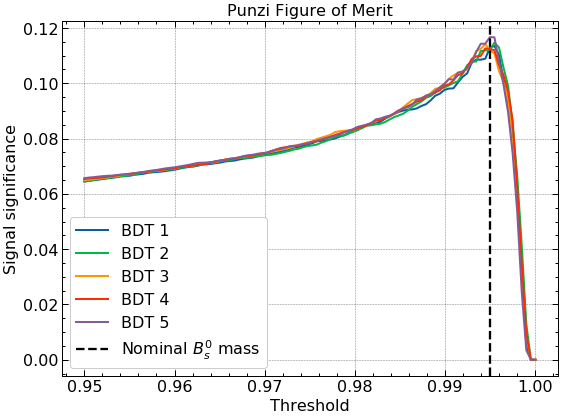

In [57]:
maximums = []

plt.figure(figsize=(8, 6))
for i in range(5):
    maximums.append(cuts[np.argmax(metrics[i][:])])
    plt.plot(cuts, metrics[i][:], label=f"BDT {i+1}")

best_cut = np.mean(maximums)
plt.axvline(best_cut, color='k', linestyle='--', linewidth=2.3, 
            label='Nominal $B_s^0$ mass')
plt.title("Punzi Figure of Merit")
plt.xlabel("Threshold")
plt.ylabel("Signal significance")
plt.legend()

plt.tight_layout()
if save==1: plt.savefig(path+'punzi'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [72]:
print('best_cut:',best_cut)

best_cut: 0.994949494949495


## 6. Estimation of the number of $B_s$ events in the data sample
Now that we defined a best cut, lets apply our classification algorithm to the full dataset and see how well it works. We will then get the "real" signal significance by fitting the selected mass distribution.  


**Ex 6.1: Apply your classifier to the full dataset and plot the mass distribution.**

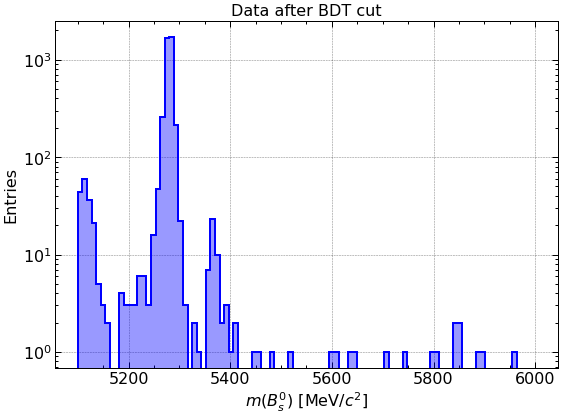

In [58]:
mass_BDT = df_data[df_data["BDT_pred"]>best_cut]["B_FitDaughtersConst_M_flat"].copy()

n_bins = 100
bins = np.linspace(5100,6000,n_bins+1)

plt.figure(figsize=(8, 6))
plt.hist(mass_BDT,
         bins=bins,
         facecolor=(0,0,1,0.4),
         edgecolor=(0,0,1,1.0),
         histtype='stepfilled',
         lw=2)

plt.yscale("log")
plt.title("Data after BDT cut")
plt.xlabel("$m(B_s^0)$ [MeV/$c^2$]")
plt.ylabel("Entries")

plt.tight_layout()
if save==1: plt.savefig(path+'dataBDTcut'+format, dpi=image_save_dpi, bbox_inches='tight')
plt.show()

You should see two peaks when plotting on a log-scale.

Now we have to find out what efficiency vs background retention we are getting here. Therefore, we need to model the entire distribution. This model should consist of two peaking structures ($B^0$ and $B_s$) and one exponential background component. To build a stable model, we first fit the peaks to their respective simulation and fix the obtained shape parameters in the fit to data. To ensure that the peaks in simulation match the peak shape in data, you need to classify both signal samples and apply the BDT cut before performing the fit.

I recommend using the [`zfit`](https://zfit.readthedocs.io/en/latest/) library for fitting. But again, this is just one of many good choices that you are free to take.

**Ex 6.2: Fit a peak to the signal simulation.**
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Maybe ONE Gaussian is not enough?</a></h4>

In [59]:
def plot_prefit(data, minuit, model, xrange, n_bins, xlabel):
    bins = np.linspace(*xrange, n_bins +1)
    counts, bins = np.histogram(data, density=False, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1]) / len(centers)

    err = np.sqrt(counts)
    err[err == 0] = 1
    counts = unp.uarray(counts, err)

    params = np.array(minuit.values)

    x = np.linspace(xrange[0], xrange[1], 1000)

    fig = plt.figure(figsize=(9, 6))

    plt.errorbar(centers, unp.nominal_values(counts), yerr=unp.std_devs(counts), color="black", lw=0, marker=".", elinewidth=1, label="Simulation")

    norm, values = model(x, *params)
    plt.plot(x, width * values, label="Fit", color="g")

    plt.xlabel(xlabel)
    plt.ylabel("Candidates")
    plt.xlim(xrange[0], xrange[1])
    #plt.yscale("log")
    plt.legend()
    
    plt.tight_layout()
    if save==1: plt.savefig(path+'B0Dfit'+format, dpi=image_save_dpi, bbox_inches='tight')
    plt.show()

In [60]:
def signal_model(x, s, mu, scale_1, scale_2):
    return s, s*(0.5*norm.pdf(x, loc = mu, scale = scale_1)+0.5*norm.pdf(x, loc = mu, scale = scale_2))

In [61]:
mass_signal = signal[signal["BDT_pred"] >= best_cut]["B_FitDaughtersConst_M_flat"]
signal_cost = cost.ExtendedUnbinnedNLL(mass_signal, signal_model)

signal_fit = Minuit(signal_cost, s=10000, mu=5366.88, scale_1 = 10, scale_2 = 10)
signal_fit.limits["s"] = (0, 100000)
signal_fit.limits["mu"] = (5200, 5500)
signal_fit.limits["scale_1"] = (0.1, 100)
signal_fit.limits["scale_2"] = (0.1, 100)
signal_fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.34e+06                  │              Nfcn = 180              │
│ EDM = 6.92e-05 (Goal: 0.0002)    │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s       │  92.39e3  │  0.30e3   │            │            │    0    │ 100000  │       │
│ 1 │ mu      │5.367141e3 │0.000018e3 │            │            │  5200   │  5500   │       │
│ 2 │ scale_1 │   3.673   │   0.020   │            │            │   0.1   │   100   │       │
│ 3 │ scale_2 │   7.778   │   0.028   │            │            │   0.1   │   100   │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────────┐
│         │         s        mu   scale_1   scale_2 │
├─────────┼─────────────────────────────────────────┤
│       s │  9.24e+04  2.11e-09  -4.7e-10  3.29e-09 │
│      mu │  2.11e-09  0.000331 -1.96e-05  2.23e-05 │
│ scale_1 │  -4.7e-10 -1.96e-05  0.000416 -8.75e-05 │
│ scale_2 │  3.29e-09  2.23e-05 -8.75e-05  0.000788 │
└─────────┴─────────────────────────────────────────┘

In [62]:
mass_signal = signal[signal["BDT_pred"] >= best_cut]["B_FitDaughtersConst_M_flat"]
signal_cost = cost.ExtendedUnbinnedNLL(mass_signal, signal_model)

signal_fit = Minuit(signal_cost, s=10000, mu=5366.88, scale_1 = 10, scale_2 = 10)
signal_fit.limits["s"] = (0, 100000)
signal_fit.limits["mu"] = (5200, 5500)
signal_fit.limits["scale_1"] = (0.1, 100)
signal_fit.limits["scale_2"] = (0.1, 100)
signal_fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.34e+06                  │              Nfcn = 180              │
│ EDM = 6.92e-05 (Goal: 0.0002)    │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s       │  92.39e3  │  0.30e3   │            │            │    0    │ 100000  │       │
│ 1 │ mu      │5.367141e3 │0.000018e3 │            │            │  5200   │  5500   │       │
│ 2 │ scale_1 │   3.673   │   0.020   │            │            │   0.1   │   100   │       │
│ 3 │ scale_2 │   7.778   │   0.028   │            │            │   0.1   │   100   │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────────┐
│         │         s        mu   scale_1   scale_2 │
├─────────┼─────────────────────────────────────────┤
│       s │  9.24e+04  2.11e-09  -4.7e-10  3.29e-09 │
│      mu │  2.11e-09  0.000331 -1.96e-05  2.23e-05 │
│ scale_1 │  -4.7e-10 -1.96e-05  0.000416 -8.75e-05 │
│ scale_2 │  3.29e-09  2.23e-05 -8.75e-05  0.000788 │
└─────────┴─────────────────────────────────────────┘

Now that you have the shape parameters of the signal mass peak, we do the same for the $B^0$ peak.

**Ex 6.3: Fit a peak to the BDT selected $B^0$ simulation.**

In [63]:
df_control_sim["BDT_pred"] = preds_proba_train =clf.predict_proba(df_control_sim[vars])[:,1]

In [64]:
mass_control = df_control_sim[df_control_sim["BDT_pred"] >= best_cut]["B_FitDaughtersConst_M_flat"]
control_cost = cost.ExtendedUnbinnedNLL(mass_control, signal_model)

control_fit = Minuit(control_cost, s=100000, mu=5279.65, scale_1 = 1, scale_2 = 5)
control_fit.limits["mu"] = (5100, 5400)
control_fit.limits["scale_1"] = (0.1, 5)
control_fit.limits["scale_2"] = (0.1, 20)
control_fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.195e+05                 │              Nfcn = 111              │
│ EDM = 2.34e-06 (Goal: 0.0002)    │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s       │  66.53e3  │  0.26e3   │            │            │         │         │       │
│ 1 │ mu      │5.279905e3 │0.000021e3 │            │            │  5100   │  5400   │       │
│ 2 │ scale_1 │   3.41    │   0.02    │            │            │   0.1   │    5    │       │
│ 3 │ scale_2 │   8.59    │   0.03    │            │            │   0.1   │   20    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────────┐
│         │         s        mu   scale_1   scale_2 │
├─────────┼─────────────────────────────────────────┤
│       s │  6.63e+04     0.029   -0.0292    -0.265 │
│      mu │     0.029  0.000435 -1.01e-05  7.22e-05 │
│ scale_1 │   -0.0292 -1.01e-05  0.000394 -0.000127 │
│ scale_2 │    -0.265  7.22e-05 -0.000127  0.000884 │
└─────────┴─────────────────────────────────────────┘

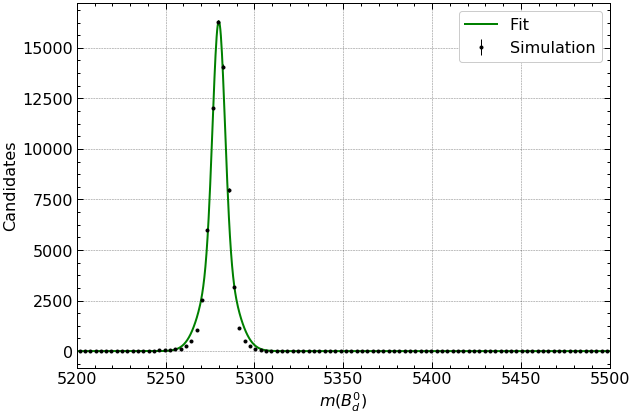

In [65]:
plot_prefit(mass_control,control_fit, signal_model, (5200,5500), 100, r"$m(B_d^0)$")

You have set up an awesome classifier but it may not be able to catch all combinatorial background in the data sample. Therefore, you should also include a background component into your model. A common choice for combinatorial background is a decreasing exponential function.

**Ex 6.4: Fit the full data mass with the fixed peak shapes and an exponential background.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Don't forget to include a scale factor for each component.
</a></h4>

In [66]:
mass_fit_range = (5200,5800)

def data_model(x, b, s_Bs, s_B0, mu_Bs, mu_B0, sigma_Bs_1, sigma_Bs_2, sigma_B0_1, sigma_B0_2 ,tau):
    return (b + s_Bs + s_B0, b* truncexpon.pdf(x, b=(mass_fit_range[1]-mass_fit_range[0])/tau, loc=mass_fit_range[0], scale=tau) +
            s_Bs * (0.5*norm.pdf(x, loc = mu_Bs, scale = sigma_Bs_1)+ 0.5*norm.pdf(x, loc = mu_Bs, scale = sigma_Bs_2)) +
            s_B0 * (0.5*norm.pdf(x, loc = mu_B0, scale = sigma_B0_1)+ 0.5*norm.pdf(x, loc = mu_B0, scale = sigma_B0_2)))

def background_func(x, b, tau):
    return b, b * truncexpon.pdf(x, b=(mass_fit_range[1]-mass_fit_range[0])/tau, loc=mass_fit_range[0], scale=tau)

In [67]:
def plot_fit(data, xrange, n_bins):
    bins = np.linspace(*xrange, n_bins +1)
    counts, bins = np.histogram(data, density=False, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.sum(bins[1:] - bins[:-1]) / len(centers)

    err = np.sqrt(counts)
    err[err == 0] = 1
    counts = unp.uarray(counts, err)

    x = np.linspace(xrange[0], xrange[1], 1000)

    fig = plt.figure(figsize=(9, 6))

    plt.errorbar(centers, unp.nominal_values(counts), yerr=unp.std_devs(counts), color="black", lw=0, marker=".", elinewidth=1, label="Data")

    _, y = data_model(x, *data_fit.values)

    plt.plot(x, width * y, label="Fit", color="cornflowerblue")

    b, y = background_func(x, data_fit.params["b"].value, 
                            data_fit.params["tau"].value)
    plt.plot(x, width*y, label="Combinatorial", ls="dashed", color="grey")
    
    s1, y = signal_model(x, data_fit.params["s_Bs"].value, 
                        data_fit.params["mu_Bs"].value, 
                        data_fit.params["sigma_Bs_1"].value,
                        data_fit.params["sigma_Bs_2"].value)
    plt.plot(x, width * y, label=r"$B_s^0$ fit", color="firebrick", ls = "dashed")
    
    s2, y = signal_model(x, data_fit.params["s_B0"].value,
                        data_fit.params["mu_B0"].value, 
                        data_fit.params["sigma_B0_1"].value,
                        data_fit.params["sigma_B0_2"].value)
    plt.plot(x, width * y, label=r"$B_d^0 fit$", color="orange", ls = "dashed")

    signal_Bs = ufloat(s1, data_fit.params["s_Bs"].error)
    signal_Bd = ufloat(s2, data_fit.params["s_B0"].error)
    background = ufloat(b, data_fit.params["b"].error)

    plt.plot([],[]," ", label=f"Signal yield ($B_s^0$): ${unc.nominal_value(signal_Bs):.0f} \pm {unc.std_dev(signal_Bs):.0f}$ ")
    plt.plot([],[]," ",label=f"Signal yield ($B_d^0$): ${unc.nominal_value(signal_Bd):.0f} \pm {unc.std_dev(signal_Bd):.0f}$ ")
    plt.plot([],[]," ",label=f"Background yield: ${unc.nominal_value(background):.0f} \pm {unc.std_dev(background):.0f}$ ")

    plt.xlabel(r"$m(\psi(2S)K_s^0)$ [MeV/$c^2$]")
    plt.ylabel(f"Candidates")
    plt.title("Fully fitted model")
    plt.xlim(xrange[0], xrange[1])
    plt.ylim(10**-1,10**4)
    plt.yscale("log")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [7,0,1,2,3,4,5,6]
    plt.legend([handles[i] for i in order], [labels[i] for i in order])
    
    plt.tight_layout()
    if save==1: plt.savefig(path+'plot_fit'+format, dpi=image_save_dpi, bbox_inches='tight')
    plt.show()

In [68]:
fit_mask = np.array(mass_BDT>mass_fit_range[0]) & np.array(mass_BDT<mass_fit_range[1])
fit_mass = mass_BDT[fit_mask]

data_cost = cost.ExtendedUnbinnedNLL(fit_mass, data_model)

data_fit = Minuit(data_cost, 
                  b = 10,
                  s_Bs = 50,
                  s_B0 = 100,
                  mu_Bs = signal_fit.params["mu"].value,
                  mu_B0 = control_fit.params["mu"].value,
                  sigma_Bs_1 = signal_fit.params["scale_1"].value,
                  sigma_Bs_2 = signal_fit.params["scale_2"].value,
                  sigma_B0_1 = control_fit.params["scale_1"].value,
                  sigma_B0_2 = control_fit.params["scale_2"].value,
                  tau = 5000)

data_fit.fixed["mu_Bs"] = True
data_fit.fixed["mu_B0"] = True
data_fit.fixed["sigma_Bs_1"] = True
data_fit.fixed["sigma_Bs_2"] = True
data_fit.fixed["sigma_B0_1"] = True
data_fit.fixed["sigma_B0_2"] = True

data_fit.limits["b"] = (0, 1000)
data_fit.limits["s_B0"] = (0, 5000)
data_fit.limits["s_Bs"] = (0, 500)
data_fit.limits["tau"] = (0, None)

data_fit.limits["tau"] = (0, None)

data_fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.134e+04                 │              Nfcn = 270              │
│ EDM = 6.7e-06 (Goal: 0.0002)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b          │    59     │     9     │            │            │    0    │  1000   │       │
│ 1 │ s_Bs       │    38     │     6     │            │            │    0    │   500   │       │
│ 2 │ s_B0       │  3.95e3   │  0.06e3   │            │            │    0    │  5000   │       │
│ 3 │ mu_Bs      │  5.37e3   │  0.05e3   │            │            │         │         │  yes  │
│ 4 │ mu_B0      │  5.28e3   │  0.05e3   │            │            │         │         │  yes  │
│ 5 │ sigma_Bs_1 │   3.67    │   0.04    │            │            │         │         │  yes  │
│ 6 │ sigma_Bs_2 │   7.78    │   0.08    │            │            │         │         │  yes  │
│ 7 │ sigma_B0_1 │   3.410   │   0.034   │            │            │         │         │  yes  │
│ 8 │ sigma_B0_2 │   8.59    │   0.09    │            │            │         │         │  yes  │
│ 9 │ tau        │ 2.6824e3  │ 0.0020e3  │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │          b       s_Bs       s_B0      mu_Bs      mu_B0 sigma_Bs_1 sigma_Bs_2 sigma_B0_1 sigma_B0_2        tau │
├────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          b │       76.3      -4.72      -12.7          0          0          0          0          0          0     -0.174 │
│       s_Bs │      -4.72       41.8      0.543          0          0          0          0          0          0      0.033 │
│       s_B0 │      -12.7      0.543   3.97e+03          0          0          0          0          0          0       2.64 │
│      mu_Bs │          0          0          0          0          0          0          0          0          0          0 │
│      mu_B0 │          0          0          0          0          0          0          0          0          0          0 │
│ sigma_Bs_1 │          0          0          0          0          0          0          0          0          0          0 │
│ sigma_Bs_2 │          0          0          0          0          0          0          0          0          0          0 │
│ sigma_B0_1 │          0          0          0          0          0          0          0          0          0          0 │
│ sigma_B0_2 │          0          0          0          0          0          0          0          0          0          0 │
│        tau │     -0.174      0.033       2.64          0          0          0          0          0          0          4 │
└────────────┴─────────────────────────────────────────────────────────────────

**Ex 6.5: Plot the fully fitted model, its 3 submodels and the selected data distribution**

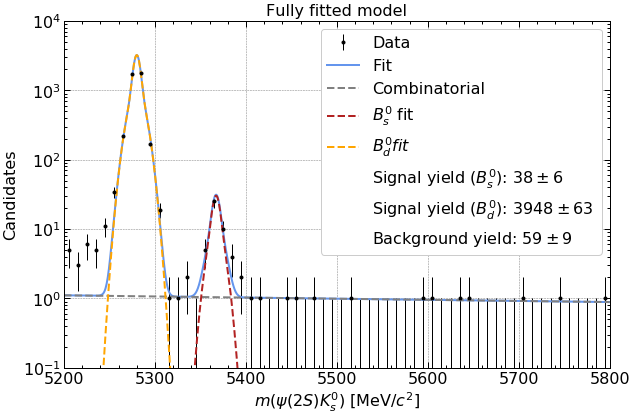

In [69]:
plot_fit(fit_mass, (5200,5800), 60)

Looking good! We see our $B_s$ peak!

Let's evaluate the statistical sigificance of our observation. The correct way of doing this is rather complicated and tedious which is beyond the scope of what we can and want to do here. Instead, we will use
$m = \frac{n_{sig}}{\sqrt{n_{sig}+n_{bkg}}}$
as a simple proxy for the statistical significance. The numbers $n_i$ are the number of signal/background events in the signal region.

**Ex 6.6: Calculate $n_{sig}$, $n_{bkg}$, and the significance proxy $m$!**

In [70]:
bkg = quad(lambda x: data_fit.values["b"] * truncexpon.pdf(x, b=(mass_fit_range[1]-mass_fit_range[0])/data_fit.values["tau"], loc=mass_fit_range[0], scale=data_fit.values["tau"]),
           *min_int)[0]
sig = quad(lambda x: data_fit.values["s_Bs"]*(0.5*norm.pdf(x, loc = data_fit.values["mu_Bs"], scale = data_fit.values["sigma_Bs_1"])+0.5*norm.pdf(x, loc = data_fit.values["mu_Bs"], scale = data_fit.values["sigma_Bs_2"])),
                                    *min_int)[0]

significance = sig/np.sqrt(sig+bkg)
print(f"Significance of signal: {significance:.2f} sigma")

Significance of signal: 5.68 sigma


**Congratulations! You did it. Now you are more than ready for a thesis at E5 :)**